In [227]:
import os
import sys
import emcee
import radvel
import corner
import george

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from george import kernels
import scipy.optimize as optimize

from scipy.optimize import minimize, Bounds
from scipy.stats import uniform, reciprocal

# Calculate the path to the src directory
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

# Now you can import your modules
from config_loader import load_config  # Assuming load_config is a function in config_loader
from data_pipeline import clean_data

The first approach is similar to the one used by C19. We fitted the
RV data using Keplerians for the planetary signals and a GP with
a quasi-periodic kernel for the stellar activity. The mathematical
expression of the kernel of this GP is

$$
GP(t_i, t_j) = \eta_1^2 exp[-\frac{|t_i-t_j|^2}{\eta_2^2} -\frac{sin^2(\pi|t_i-t_j|/\eta_3)}{2\eta_4^2}] 
$$

$$
\eta_1 = \text{amplitude of the covariance; Arv}
$$
$$
\eta_2 = \text{decay timescale; } \tau_{\text{decay}}
$$
$$
\eta_3 = \text{period of recurrence of the covariance; } P_{\text{rot}}
$$
$$
\eta_4 = \text{periodic coherence scale; } \gamma
$$


where Arv is the amplitude of the covariance, τdecay is the decay timescale, Prot is the period of recurrence of the covariance,
and γ is the periodic coherence scale (e.g., Grunblatt et al. 2015).
We used the Python package george

In [2]:
# Load the config file
config = load_config('../config.ini')

# Data paths
espresso_path = config['Paths']['espresso']
harps_path = config['Paths']['harps']

# Clean the data
combined_df,\
harps_df,\
cleaned_harps_df,\
espresso_df,\
cleaned_espresso_df,\
cleaned_pre_df,\
cleaned_post_df = clean_data(espresso_path, harps_path)

In [30]:
combined_df.head()

Time           RV      e_RV         FWHM    e_FWHM        BIS  \
0  2.458437e+06 -5573.437416  0.816913  4499.263409  1.633825  20.033978   
1  2.458445e+06 -5576.693982  0.793815  4498.810086  1.587631  19.357431   
2  2.458464e+06 -5580.193552  0.653161  4507.480887  1.306323   20.52243   
3  2.458471e+06 -5579.244790  0.676495  4503.037787  1.352990  16.917991   
4  2.458489e+06 -5578.568851  1.060688  4510.972651  2.121377  22.321148   

      e_BIS   Contrast  e_Contrast    Sindex  ...    Halpha  e_Halpha  \
0  1.633825  42.799587    0.015542  0.598479  ...  0.600940  0.000142   
1  1.587631  42.597043    0.015033  0.688857  ...  0.596644  0.000139   
2  1.306323  42.765184    0.012394  0.672483  ...  0.600782  0.000109   
3  1.352990  42.717744    0.012835  0.613767  ...  0.616538  0.000113   
4  2.121377  42.689840    0.020076  0.714336  ...  0.602749  0.000190   

        NaD     e_NaD      BERV  Inst Hbeta  e_Hbeta  Hgamma  e_Hgamma  
0  0.067823  0.000083  3.416847   Pre   NaN      NaN     NaN       NaN  
1  0.073309  0.000082  4.175202   Pre   NaN      NaN     NaN       NaN  
2  0.064390  0.000062  5.718515   Pre   NaN      NaN     NaN       NaN  
3  0.061649  0.000064  6.179283   Pre   NaN      NaN     NaN       NaN  
4  0.068562  0.000113  6.850254   Pre   NaN      NaN     NaN       NaN  

[5 rows x 21 columns]

In [70]:
time_pre = cleaned_pre_df['Time']
time_post = cleaned_post_df['Time']
time_harps = cleaned_harps_df['Time']

rv_pre = cleaned_pre_df['RV']
rv_post = cleaned_post_df['RV']
rv_harps = cleaned_harps_df['RV']

e_rv_pre = cleaned_pre_df['e_RV']
e_rv_post = cleaned_post_df['e_RV']
e_rv_harps = cleaned_harps_df['e_RV']

In [464]:
print(min(time_harps))

2458408.853661


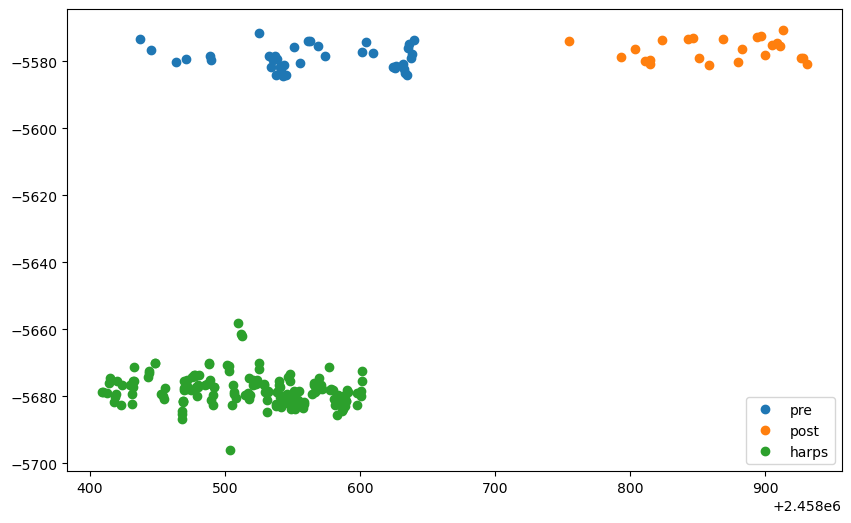

In [32]:
# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(harps_df['Time'], harps_df['RV'], 'o', label='harps')
plt.legend()

# Instrumental Model

## Offset term priors

ESPRESSOpre as RV reference, meaning that v0 was measured with the data coming from this instrument. 

Model the RV
offsets with the other two instruments with two offset parameters
$∆RV_{HARPS/pre}$ and $∆RV_{post/pre}$.

And then a jitter term for each instrument.


I will set these up with priors as follows

Prior PDF of the offsets between the RV instruments (∆RVHARPS {pre, ∆RVpost{pre) are
Gaussian distributions with means equal to the difference of the
median values of the data sets and variances equal to the sum
of their variances.

And the prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
se

In [75]:
## Instrumental model priors for RV instrumental offset

# mean = difference in median values of data
# variance = sum of variances
rv_harps = cleaned_harps_df['RV'].copy()
rv_pre = cleaned_pre_df['RV'].copy()    # Reference
rv_post = cleaned_post_df['RV'].copy()

# median values
median_harps = np.median(rv_harps)
median_pre = np.median(rv_pre)
median_post = np.median(rv_post)

# variances
var_harps = np.var(rv_harps, ddof=1)
var_pre = np.var(rv_pre, ddof=1)
var_post = np.var(rv_post, ddof=1)

# offset mean
rv_offset_mean_harps_pre = median_harps - median_pre    # -99.35521000000062
rv_offset_mean_post_pre = median_post - median_pre    # 2.8595649999997477

# offset variance
rv_offset_var_harps_pre = np.sqrt(var_harps + var_pre)  # 4.911649037727071
rv_offset_var_post_pre = np.sqrt(var_post + var_pre)    # 4.654121588541066

# v0
v0_mean = median_pre
v0_variance = var_pre

print(rv_offset_mean_harps_pre, rv_offset_var_harps_pre)
print(rv_offset_mean_post_pre, rv_offset_var_post_pre)
print(v0_mean, np.sqrt(v0_variance))

'''# corrected RVs
rv_harps_corrected = rv_harps - rv_offset_mean_harps_pre
rv_post_corrected = rv_post - rv_offset_mean_post_pre

# Update the original DataFrames directly
cleaned_harps_df.loc[:, 'RV'] = rv_harps_corrected
cleaned_post_df.loc[:, 'RV'] = rv_post_corrected

# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(cleaned_harps_df['Time'], cleaned_harps_df['RV'], 'o', label='harps')
plt.legend()

# Merge the adjusted data
combined_adjusted_df = pd.concat([cleaned_pre_df, cleaned_post_df, cleaned_harps_df], ignore_index=True)'''



-99.35521000000062 4.950649297120366
2.8595649999997477 4.733139014084523
-5579.24479 3.4584860369889427


"# corrected RVs\nrv_harps_corrected = rv_harps - rv_offset_mean_harps_pre\nrv_post_corrected = rv_post - rv_offset_mean_post_pre\n\n# Update the original DataFrames directly\ncleaned_harps_df.loc[:, 'RV'] = rv_harps_corrected\ncleaned_post_df.loc[:, 'RV'] = rv_post_corrected\n\n# quick plot\nplt.figure(figsize=(10, 6))\nplt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')\nplt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')\nplt.plot(cleaned_harps_df['Time'], cleaned_harps_df['RV'], 'o', label='harps')\nplt.legend()\n\n# Merge the adjusted data\ncombined_adjusted_df = pd.concat([cleaned_pre_df, cleaned_post_df, cleaned_harps_df], ignore_index=True)"

## Jitter term priors

The prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
set.

In [69]:
# error bars for RVs
rv_harps_err = cleaned_harps_df['e_RV']
rv_pre_err = cleaned_pre_df['e_RV']
rv_post_err = cleaned_post_df['e_RV']

# median values
median_harps_err = np.median(rv_harps_err)
median_pre_err = np.median(rv_pre_err)
median_post_err = np.median(rv_post_err)

# five tims the median value
rv_harps_err_max = 5 * median_harps_err
rv_pre_err_max = 5 * median_pre_err
rv_post_err_max = 5 * median_post_err

print(rv_pre_err_max, rv_post_err_max, rv_harps_err_max)

3.97059 3.2853200000000005 10.5


# RV Model

### Data Preperation

In [320]:
# Data preparation
time_pre, rv_pre, e_rv_pre = cleaned_pre_df['Time'].values, cleaned_pre_df['RV'].values, cleaned_pre_df['e_RV'].values
time_post, rv_post, e_rv_post = cleaned_post_df['Time'].values, cleaned_post_df['RV'].values, cleaned_post_df['e_RV'].values
time_harps, rv_harps, e_rv_harps = cleaned_harps_df['Time'].values, cleaned_harps_df['RV'].values, cleaned_harps_df['e_RV'].values

### Function Definitions

In [321]:
# Define the kernel using parameter values that will be sampled by MCMC
def create_kernel(A_RV, P_rot, tau_decay, gamma):
    # Quasi-periodic kernel
    kernel = A_RV**2 * kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P_rot)) * kernels.ExpSquaredKernel(metric=tau_decay**2)
    return kernel

# radvel custom functions
def calculate_orbital_phase(tic, tref, period):
    return ((tic - tref) / period) % 1

# radvel custom priors
def beta_prior(value, alpha, beta):
    return stats.beta.logpdf(value, alpha, beta)

def uniform_prior(value, lower, upper):
    return stats.uniform.logpdf(value, lower, upper)

### Stellar Activity Model

In [440]:
def stellar_activity_log_prior(params):
    
    # Unpack the gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params

    # Unifrom priors; A_RV, gamma
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)

    # P_rot, tau_decay; Additonal logic
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    if tau_decay < P_rot / 2:
        return -np.inf  
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    return prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma

def stellar_activity_log_likelihood(gp, instrumental_offset, *args):
        
    # Unpack the instrumental offset
    rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps = instrumental_offset

    # Unpack the rv data
    time_pre, _, _, time_post, _, _, time_harps, _, _ = args

    # Compute the ll for each instrument GP
    gp.compute(time_pre, err_pre)
    ll_pre = gp.log_likelihood(rv_pre_adjusted)
    gp.compute(time_post, err_post)
    ll_post = gp.log_likelihood(rv_post_adjusted)
    gp.compute(time_harps, err_harps)
    ll_harps = gp.log_likelihood(rv_harps_adjusted)

    return ll_pre + ll_post + ll_harps

def stellar_activity_model(params):
        
    # Unpack the gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params

    # Create the kernel
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    return gp        

### Instrumental Model

In [441]:
def instrumental_log_priors(params):

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params

    # Uniform priors
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)

    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    return prior_jitter_pre + prior_jitter_post + prior_jitter_harps + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre

def instrumental_offset(params, *args):

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params

    _, rv_pre, e_rv_pre, _, rv_post, e_rv_post, _, rv_harps, e_rv_harps = args

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    return rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps

### Planetary Model

In [512]:
def planetary_log_priors(params):
    try:
        # Unpack the planetary parameters
        per1, tc1, secosw1, sesinw1, k1, per2, tc2, secosw2, sesinw2, k2, per3, tc3, secosw3, sesinw3, k3 = params

        # Calculate eccentricity, omega and phase
        e1 = np.sqrt(secosw1**2 + sesinw1**2)
        e2 = np.sqrt(secosw2**2 + sesinw2**2)
        e3 = np.sqrt(secosw3**2 + sesinw3**2)
        omega1 = np.arctan2(sesinw1, secosw1)
        omega2 = np.arctan2(sesinw2, secosw2)
        omega3 = np.arctan2(sesinw3, secosw3)
        phi1 = calculate_orbital_phase(tc1, 0, per1)
        phi2 = calculate_orbital_phase(tc2, 0, per2)
        phi3 = calculate_orbital_phase(tc3, 0, per3)

        # Check and clip omega3 to avoid potential range issues
        omega3 = np.clip(omega3, -np.pi, np.pi)

        print(f"Omega Values: {omega1}, {omega2}, {omega3}")
        print(f"Secosw and Sesinw for omega3: {secosw3}, {sesinw3}")

        # Priors
        epsilon = 1e-6
        omega1_prior = stats.uniform.logpdf(omega1, -np.pi, np.pi)
        omega2_prior = stats.uniform.logpdf(omega2, -np.pi, np.pi)
        omega3 = np.mod(omega3 + np.pi, 2 * np.pi) - np.pi
        omega3_prior = stats.uniform.logpdf(omega3, -np.pi, np.pi)

        
        k1_prior = stats.uniform.logpdf(k1, 0, 17)
        k2_prior = stats.uniform.logpdf(k2, 0, 17)
        k3_prior = stats.uniform.logpdf(k3, 0, 17)
        phi1_prior = stats.uniform.logpdf(phi1, 0, 1)
        phi2_prior = stats.uniform.logpdf(phi2, 0, 1)
        phi3_prior = stats.uniform.logpdf(phi3, 0, 1)
        per1_prior = -np.log(per1)
        per2_prior = -np.log(per2)
        per3_prior = -np.log(per3)

        if any(e < 0 or e > 1 for e in [e1, e2, e3]):
             print(f"Invalid eccentricity values: e1={e1}, e2={e2}, e3={e3}")
             return -np.inf

        e1_prior = stats.beta.logpdf(e1, 0.867, 3.03)
        e2_prior = stats.beta.logpdf(e2, 0.867, 3.03)
        e3_prior = stats.beta.logpdf(e3, 0.867, 3.03)

        total_prior = (omega1_prior + omega2_prior + omega3_prior + k1_prior + k2_prior + k3_prior + 
                       phi1_prior + phi2_prior + phi3_prior + per1_prior + per2_prior + per3_prior + 
                       e1_prior + e2_prior + e3_prior)
        if not np.isfinite(total_prior):
            print("Some component of the prior calculation returned -inf.")
            print("Detailed prior values:", omega1_prior, omega2_prior, omega3_prior, k1_prior, k2_prior, k3_prior, 
                  phi1_prior, phi2_prior, phi3_prior, per1_prior, per2_prior, per3_prior, e1_prior, e2_prior, e3_prior)

        return total_prior
    except Exception as e:
        print("Error in planetary_log_priors:", e)
        raise


def planetary_likelihood(mod, instrumental_offset, *args):
        
        # Unpack the instrumental offset
        rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps = instrumental_offset

        # Unpack the rv data
        time_pre, _, _, time_post, _, _, time_harps, _, _ = args

        # Compute the ll for each instrument Radvel 
        # TODO: Check if the likelihood is correct and if radvels composite likelihood is the same
        # TODO: Check gives out log likelihood
        ll_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre).logprob()
        ll_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post).logprob()
        ll_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps).logprob()

        return ll_pre + ll_post + ll_harps

def planetary_model(params):

        # Unpack the planetary parameters
        per1, tc1, secosw1, sesinw1, k1, per2, tc2, secosw2, sesinw2, k2, per3, tc3, secosw3, sesinw3, k3 = params
        
        time_base = 0   #2458408.853661
        params = radvel.Parameters(3, basis='per tc secosw sesinw k')

        # L 98-59 b
        params['per1'] = radvel.Parameter(value=per1)
        params['tc1'] = radvel.Parameter(value=tc1)
        params['secosw1'] = radvel.Parameter(value=secosw1)
        params['sesinw1'] = radvel.Parameter(value=sesinw1)
        params['k1'] = radvel.Parameter(value=k1)

        # L 98-59 c
        params['per2'] = radvel.Parameter(value=per2)
        params['tc2'] = radvel.Parameter(value=tc2)
        params['secosw2'] = radvel.Parameter(value=secosw2)
        params['sesinw2'] = radvel.Parameter(value=sesinw2)
        params['k2'] = radvel.Parameter(value=k2)

        # L 98-59 d
        params['per3'] = radvel.Parameter(value=per3)
        params['tc3'] = radvel.Parameter(value=tc3)
        params['secosw3'] = radvel.Parameter(value=secosw3)
        params['sesinw3'] = radvel.Parameter(value=sesinw3)
        params['k3'] = radvel.Parameter(value=k3)

        mod = radvel.RVModel(params, time_base=time_base)

        return mod

### Combined Model

In [513]:
def total_log_likelihood(params, *args):

    # Unpack the parameters
    stellar_params = params[:4]
    instrumental_params = params[4:10]
    planetary_params = params[10:]

    # Initialise models
    gp = stellar_activity_model(stellar_params)
    mod = planetary_model(planetary_params)

    # Unpack the instrumental offset
    inst_offset = instrumental_offset(instrumental_params, *args)

    # Compute the log priors
    log_prior_stellar = stellar_activity_log_prior(stellar_params)
    log_prior_instrumental = instrumental_log_priors(instrumental_params)
    log_prior_planetary = planetary_log_priors(planetary_params)

    # Compute the log likelihoods
    log_likelihood_stellar = stellar_activity_log_likelihood(gp, inst_offset, *args)
    log_likelihood_planetary = planetary_likelihood(mod, inst_offset, *args)

    return log_prior_stellar + log_prior_instrumental + log_prior_planetary + log_likelihood_stellar + log_likelihood_planetary

### Run ll

In [514]:
args = time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,    # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,    # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5,    # jitter_harps U(0, 11)
    2.25, # RadVel per1
    1366.17, # RadVel tc1
    -0.027, # RadVel secosw1
    -0.028, # RadVel sesinw1
    0.46,  # RadVel k1
    3.69,  # RadVel per2
    1367.27, # RadVel tc2
    -0.14,  # RadVel secosw2
    -0.099, # RadVel sesinw2
    2.19,  # RadVel k2
    7.45,  # RadVel per3
    1362.74, # RadVel tc3
    -0.062, # RadVel secosw3
    0,     # RadVel sesinw3
    1.50   # RadVel k3
]


total_log_likelihood(params, *args)

Omega Values: -2.3380146751193664, -2.526088894690878, 3.141592653589793
Secosw and Sesinw for omega3: -0.062, 0


-1372.1277058074452

In [504]:
def log_prob(params, *args):
    lp = total_log_likelihood(params, *args)
    if not np.isfinite(lp):
        return -np.inf
    return lp

ndim, nwalkers = len(params), 50
pos = params + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps))

# Run MCMC
sampler.run_mcmc(pos, 50, progress=True)

Omega Values: -2.341109342917862, -2.526075906237744, -3.138626054518723
Secosw and Sesinw for omega3: -0.06201891553694278, -0.00018398579695622552
Omega Values: -2.337806223527192, -2.527478627553179, -3.140557740860315
Secosw and Sesinw for omega3: -0.061928364360288916, -6.409047547346078e-05
Omega Values: -2.3427916641954245, -2.5262276718531713, 3.1410359304654882
Secosw and Sesinw for omega3: -0.06194066689422612, 3.4483805157526035e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108992249451069 -1.3056749275009158 -2.0082031827616054 1.2018018336839784 0.7029044122256759 1.090684074404536
Omega Values: -2.335045287720119, -2.5259106462696823, 3.140856826049231
Secosw and Sesinw for omega3: -0.062020018364829614, 4.563604581542392e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.144729885849400

  0%|          | 0/50 [00:00<?, ?it/s]

Omega Values: -2.339618228772974, -2.525996757452124, -3.1397506237120045
Secosw and Sesinw for omega3: -0.0620198375431019, -0.00011424252298114986
Omega Values: -2.3346358160906155, -2.5282777805760617, -3.1395419828385633
Secosw and Sesinw for omega3: -0.06192051560551097, -0.00012697876824585607
Omega Values: -2.3351421758368742, -2.5257700552999682, 3.1412659291110354
Secosw and Sesinw for omega3: -0.06199667108282365, 2.0255830765030406e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109186563888483 -1.3056708355193247 -2.008222311206865 1.200775735878751 0.7031508644885325 1.0904427037147872
Omega Values: -2.3376982465250524, -2.5255231511322953, 3.1408918415195717
Secosw and Sesinw for omega3: -0.06204885205904616, 4.34845915853499e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494

  2%|▏         | 1/50 [00:00<00:07,  6.60it/s]

Omega Values: -2.3320994746560397, -2.525256835131853, 3.1398561216195326
Secosw and Sesinw for omega3: -0.062061148012099276, 0.00010777127596376627
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110022504823532 -1.3056655496721936 -2.008216586563611 1.2010083090469612 0.7036261684700823 1.090164522030711
Omega Values: -2.3384587551217733, -2.5253480169520426, -3.1413223073794967
Secosw and Sesinw for omega3: -0.06198237444948523, -1.675670044583574e-05
Omega Values: -2.338613769213838, -2.525255357909253, -3.1394928975757654
Secosw and Sesinw for omega3: -0.061933209140945515, -0.00013004481948326153
Omega Values: -2.3429828608304972, -2.5262588345731603, 3.140959404188893
Secosw and Sesinw for omega3: -0.06208074034164763, 3.9312596883631814e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.14472988584

  4%|▍         | 2/50 [00:00<00:07,  6.78it/s]

Omega Values: -2.3396924459104005, -2.5257877004240776, 3.1415538193541512
Secosw and Sesinw for omega3: -0.062011179705094455, 2.40815676632294e-06
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109733558483351 -1.305645624803924 -2.008208532515993 1.2014490826470259 0.7034048212266506 1.0903801970202398
Omega Values: -2.34126864878272, -2.5263131032344095, -3.1385573566392275
Secosw and Sesinw for omega3: -0.0620186191177623, -0.0001882455035904774
Omega Values: -2.3380345275643677, -2.524898611522057, 3.140874035927417
Secosw and Sesinw for omega3: -0.06205248144128905, 4.45920168339025e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109156513644656 -1.3055810058910988 -2.008211688730300

  6%|▌         | 3/50 [00:00<00:07,  5.93it/s]

Omega Values: -2.328739539475358, -2.5248831337346744, 3.1412631740192007
Secosw and Sesinw for omega3: -0.061916977549589594, 2.0400379913613e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109761337436264 -1.3056224963009437 -2.0081787858162072 1.2024852431459603 0.7033346449189154 1.0907862412638052
Omega Values: -2.3334670569764273, -2.5252540232172027, -3.1401157288890773
Secosw and Sesinw for omega3: -0.06197430288344354, -9.153144529093871e-05
Omega Values: -2.3405533589231986, -2.5253481985154287, -3.1412029593782753
Secosw and Sesinw for omega3: -0.06188850890945511, -2.411759490232227e-05
Omega Values: -2.3410028255448867, -2.526009928749831, 3.1412568462740236
Secosw and Sesinw for omega3: -0.06213210885399347, 2.0864417481641687e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.144729885849

  8%|▊         | 4/50 [00:00<00:07,  5.83it/s]

Omega Values: -2.34120462803052, -2.526778911475063, -3.1381579862478053
Secosw and Sesinw for omega3: -0.06212935521900388, -0.00021339450648417502
Omega Values: -2.3363415385745143, -2.5271834041263825, -3.1403833662483267
Secosw and Sesinw for omega3: -0.06210169759150463, -7.509883338856782e-05
Omega Values: -2.3377903747662017, -2.525954137317691, -3.1410962149054127
Secosw and Sesinw for omega3: -0.061940633872161505, -3.074972931529923e-05
Omega Values: -2.3413730294675066, -2.5259222956222476, -3.137602018165393
Secosw and Sesinw for omega3: -0.06202462325386064, -0.00024751897267066153
Omega Values: -2.3374043842555863, -2.5258667504356547, -3.1399572681934647
Secosw and Sesinw for omega3: -0.06202733069916813, -0.00010143868123076379
Omega Values: -2.3365826280931516, -2.5267201439091713, 3.141244740805387
Secosw and Sesinw for omega3: -0.06199859918678971, 2.1570106142645656e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002

 10%|█         | 5/50 [00:00<00:07,  6.08it/s]

Omega Values: -2.3339323895202955, -2.525990110530255, 3.140595136165591
Secosw and Sesinw for omega3: -0.06210012688222785, 6.194597915645838e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109808405932443 -1.305692514505507 -2.0081993932817994 1.2007818137894655 0.7029642032699457 1.0899969201818696
Omega Values: -2.3425327929969035, -2.526018281519018, -3.138879406552732
Secosw and Sesinw for omega3: -0.06200930881498277, -0.00016824698627447714
Omega Values: -2.345028685424478, -2.5259127416352083, -3.1333470010584943
Secosw and Sesinw for omega3: -0.062065479575524274, -0.0005117819776403584
Omega Values: -2.3338195589641395, -2.524138841479203, 3.136919749867183
Secosw and Sesinw for omega3: -0.06209802812393203, 0.00029018021891807043
Some component of the prior calculation returned -inf.
Detailed prior values: -1.144729885849400

 12%|█▏        | 6/50 [00:00<00:07,  6.18it/s]

Omega Values: -2.3425704303996886, -2.5253910601416627, -3.1411677168133165
Secosw and Sesinw for omega3: -0.06179909632564254, -2.62607103624267e-05
Omega Values: -2.341252942947728, -2.525844853284755, -3.1402736247575866
Secosw and Sesinw for omega3: -0.062230655914327256, -8.208407700242761e-05
Omega Values: -2.339811610780627, -2.525506537009631, -3.1403032480070587
Secosw and Sesinw for omega3: -0.061723745430609565, -7.958698605173926e-05
Omega Values: -2.3394952618839886, -2.526326461707495, 3.140298484187256
Secosw and Sesinw for omega3: -0.061950319277119144, 8.017425244646144e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108965256150986 -1.3056194459260038 -2.0082169254551654 1.201848338912205 0.7032131658885442 1.0906422797290698
Omega Values: -2.3430848371964332, -2.523049981087686, 3.1409874952202483
Secosw and Sesinw fo

 14%|█▍        | 7/50 [00:01<00:06,  6.27it/s]

Omega Values: -2.339820797455433, -2.5261065072468627, 3.1400746770383376
Secosw and Sesinw for omega3: -0.061789966480206425, 9.37957922752771e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109204172498463 -1.305652678204572 -2.008225725384793 1.2023031489746612 0.7031720814243123 1.0913338850284329
Omega Values: -2.3351748343611853, -2.5257815686862557, -3.1415475773691393
Secosw and Sesinw for omega3: -0.06197629607292646, -2.793657199005147e-06
Omega Values: -2.3478867800841714, -2.526491028064637, -3.136608797312347
Secosw and Sesinw for omega3: -0.06204530804633804, -0.0003092274582791346
Omega Values: -2.3362717192079043, -2.52541061968094, 3.1404791643265266
Secosw and Sesinw for omega3: -0.06192385762511817, 6.895157910235438e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 

 16%|█▌        | 8/50 [00:01<00:06,  6.23it/s]

Omega Values: -2.3417210712422336, -2.5257559468413215, 3.141059830213516
Secosw and Sesinw for omega3: -0.0619177153758227, 3.2991209279993396e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110327810204506 -1.305718281506652 -2.008166377771489 1.200726631661204 0.7036002405505284 1.090783036339709
Omega Values: -2.3424705269212756, -2.5267176336777575, -3.1407571769074765
Secosw and Sesinw for omega3: -0.061907511848744386, -5.172229464429669e-05
Omega Values: -2.3405224909765803, -2.5269985584554484, 3.140446522749775
Secosw and Sesinw for omega3: -0.061927444384211536, 7.097698493109304e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109475781617707 -1.305648556777646 -2.008232738367

 18%|█▊        | 9/50 [00:01<00:06,  6.37it/s]

Omega Values: -2.341741702162051, -2.526141167723717, -3.1388474632117633
Secosw and Sesinw for omega3: -0.06195420606837511, -0.00017007651761379418
Omega Values: -2.3404971464365736, -2.5251841125766243, 3.1411094512366766
Secosw and Sesinw for omega3: -0.06190976215485287, 2.9914945082337197e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109257930265233 -1.305603646232857 -2.0082139871311107 1.2021442171722732 0.7034780854462177 1.090817338395963
Omega Values: -2.324351661162517, -2.5253684686809055, 3.1413317714866698
Secosw and Sesinw for omega3: -0.06239238597079525, 1.6277057240221494e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109796728139266 -1.3056459818067632 -2.008193593

 20%|██        | 10/50 [00:01<00:06,  6.28it/s]

Omega Values: -2.340704960206755, -2.5257465998072623, -3.140054269111055
Secosw and Sesinw for omega3: -0.062224722410014845, -9.572562266499328e-05
Omega Values: -2.338809500500275, -2.5270131809589502, -3.141295112950516
Secosw and Sesinw for omega3: -0.06210736586766119, -1.8479465889411343e-05
Omega Values: -2.337261532429589, -2.525892799755482, -3.1407206055274903
Secosw and Sesinw for omega3: -0.06191152824916723, -5.398984192974496e-05
Omega Values: -2.3389139028958796, -2.5264335554457626, -3.1412002583283862
Secosw and Sesinw for omega3: -0.061953938311737324, -2.4310433066746996e-05
Omega Values: -2.340366744445554, -2.5263483356290264, -3.1388631511772402
Secosw and Sesinw for omega3: -0.06191923479735209, -0.00016900912047933614
Omega Values: -2.3402361715339164, -2.525965916876194, -3.136025417838374
Secosw and Sesinw for omega3: -0.062068480937347195, -0.00034555343615890827
Omega Values: -2.340686471124247, -2.524976247870388, -3.141039932920358
Secosw and Sesinw for o

 22%|██▏       | 11/50 [00:01<00:06,  6.38it/s]

Omega Values: -2.3380382173131418, -2.527734722715718, -3.139893813906186
Secosw and Sesinw for omega3: -0.06191529734818181, -0.0001051842653466997
Omega Values: -2.3368234496082123, -2.5260215871209186, 3.14083192630512
Secosw and Sesinw for omega3: -0.06205385576219222, 4.720607030362479e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109572298103277 -1.305671107148038 -2.0082098932131256 1.2012321296379858 0.7029733112449903 1.0901962590037724
Omega Values: -2.370631109454858, -2.5276223820042825, -3.1234542355365966
Secosw and Sesinw for omega3: -0.06233660313780419, -0.0011308113835977137
Omega Values: -2.3360604165762675, -2.525700719544105, 3.140184407220474
Secosw and Sesinw for omega3: -0.062083760957987094, 8.742928875813045e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 

 26%|██▌       | 13/50 [00:02<00:05,  6.61it/s]

Omega Values: -2.3427239812357277, -2.5260070930810214, -3.140609676071671
Secosw and Sesinw for omega3: -0.06187005646306268, -6.0816894136139215e-05
Omega Values: -2.340672870280507, -2.5268800364807174, -3.1411439112913677
Secosw and Sesinw for omega3: -0.062046977501637186, -2.784310516335445e-05
Omega Values: -2.338226465178173, -2.5276031254390134, 3.1396893917444184
Secosw and Sesinw for omega3: -0.0619438193775645, 0.00011789545033319654
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110503704853318 -1.3056012800220935 -2.0081893980000904 1.2006954653333095 0.7027722433685429 1.090670041097468
Omega Values: -2.3341596758913483, -2.5263654311599897, 3.1413294467394755
Secosw and Sesinw for omega3: -0.062165500811561844, 1.6362386044887467e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858

 28%|██▊       | 14/50 [00:02<00:05,  6.63it/s]

Omega Values: -2.3408901209154687, -2.526538123261246, -3.1376172376864675
Secosw and Sesinw for omega3: -0.06204820559196097, -0.0002466687227296961
Omega Values: -2.333918033374151, -2.5261315096472936, -3.141063258919786
Secosw and Sesinw for omega3: -0.061986165706653794, -3.281514880486584e-05
Omega Values: -2.3414817358747175, -2.5240087110891514, -3.140818875350265
Secosw and Sesinw for omega3: -0.06206781668952387, -4.802673551443388e-05
Omega Values: -2.3359235643214538, -2.526039659393783, -3.1414153364581927
Secosw and Sesinw for omega3: -0.062061228719942296, -1.1004519175546455e-05
Omega Values: -2.3361846997143947, -2.5263370363072695, 3.1408446873382827
Secosw and Sesinw for omega3: -0.06192167661609168, 4.631533298286988e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109515526689373 -1.3056246023882239 -2.00821634200458

 30%|███       | 15/50 [00:02<00:05,  6.50it/s]

Omega Values: -2.3249203493928996, -2.527663913253195, 3.123283245884844
Secosw and Sesinw for omega3: -0.06141228268632792, 0.0011245481870202911
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8112033519341748 -1.3055325088470848 -2.008256202834997 1.2020283281096344 0.7022745623658393 1.0929221004139877
Omega Values: -2.329209187056591, -2.5263093629424405, 3.138987349524675
Secosw and Sesinw for omega3: -0.06201771603307571, 0.0001615753732606358
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109965769935423 -1.3055501796958942 -2.008188825366088 1.1995468462576784 0.7040366134042982 1.0903511261140286
Omega Values: -2.347824988414531, -2.525756474267413, -3.131916278830099
Secosw and Sesinw

 34%|███▍      | 17/50 [00:02<00:05,  6.55it/s]

Omega Values: -2.3393695968078223, -2.5279137020008076, 3.140511648078659
Secosw and Sesinw for omega3: -0.0618074188084686, 6.681418638669514e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109603149810117 -1.305636559211387 -2.0082963022740468 1.2020130346427436 0.7023172992612785 1.0912587145723833
Omega Values: -2.342470879762989, -2.526535127363035, 3.141497236189885
Secosw and Sesinw for omega3: -0.06192019372987656, 5.908263905432587e-06
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8111003424993184 -1.3056278905163394 -2.008201038850345 1.19966739883329 0.7023527282884143 1.0907723864569616
Omega Values: -2.337823162576952, -2.530141408098561, -3.132472093294251
Secosw and Sesinw fo

 36%|███▌      | 18/50 [00:03<00:07,  4.38it/s]

Omega Values: -2.3366980140155764, -2.5305650526944494, -3.1361105560828064
Secosw and Sesinw for omega3: -0.061793847749357145, -0.0003387632923628051
Omega Values: -2.338086726767073, -2.5298240950032946, -3.13906239229913
Secosw and Sesinw for omega3: -0.06182620286762162, -0.00015643678171244107
Omega Values: -2.3350257831928456, -2.5260629992186217, 3.1390723165449135
Secosw and Sesinw for omega3: -0.06210870967884794, 0.00015653521325579423
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.810986339007638 -1.305636884890011 -2.0082044001118278 1.2016336924943483 0.7028629688680714 1.0899592465472596
Omega Values: -2.3535247302728624, -2.5269297424644552, -3.1313534972628787
Secosw and Sesinw for omega3: -0.062177593116649076, -0.0006366683456130143
Omega Values: -2.3721072220823247, -2.524145401455259, -3.1119980105641916
Secosw and Sesi

 38%|███▊      | 19/50 [00:03<00:06,  4.55it/s]

Omega Values: -2.346264227232561, -2.5256966392710596, -3.1337100903553434
Secosw and Sesinw for omega3: -0.062064938935334324, -0.00048924093880515
Omega Values: -2.3420948152154386, -2.5258589831110494, -3.1399678330908274
Secosw and Sesinw for omega3: -0.062207762067989496, -0.00010107653595163682
Omega Values: -2.3422335560755903, -2.5282161779808816, -3.1408254562943254
Secosw and Sesinw for omega3: -0.062183914883869165, -4.770734068055577e-05
Omega Values: -2.336667512963594, -2.52650606622021, -3.140746597563313
Secosw and Sesinw for omega3: -0.06199975006775521, -5.2455274701107454e-05
Omega Values: -2.3432169099593128, -2.5260342758087413, -3.1350188116416846
Secosw and Sesinw for omega3: -0.06193183198223071, -0.0004071359398721266
Omega Values: -2.3289638084864346, -2.525980996578301, 3.1409826710972926
Secosw and Sesinw for omega3: -0.06196875293272535, 3.779985905924511e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -

 40%|████      | 20/50 [00:03<00:05,  5.02it/s]

Omega Values: -2.3345483976333914, -2.5255273576700756, -3.1405574698917067
Secosw and Sesinw for omega3: -0.06211681222663171, -6.430233436302226e-05
Omega Values: -2.3374952216294216, -2.5264040741480454, 3.1402216087999943
Secosw and Sesinw for omega3: -0.06189194673650379, 8.485668427377335e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109357259561866 -1.3056452777006222 -2.0082244787232435 1.202229990878792 0.7032729335073304 1.0908939485188691
Omega Values: -2.337537938006478, -2.525956165647796, -3.1413426668213167
Secosw and Sesinw for omega3: -0.061994714112763395, -1.5497858566508437e-05
Omega Values: -2.3338154376603377, -2.52542340664205, -3.1403909950827003
Secosw and Sesinw for omega3: -0.062255633427910156, -7.481004753126367e-05
Omega Values: -2.3340628816263234, -2.525761453743811, -3.1377892933023546
Secosw and Sesin

 42%|████▏     | 21/50 [00:03<00:05,  5.30it/s]

Omega Values: -2.336625507997102, -2.5251266314111698, -3.1308920453541056
Secosw and Sesinw for omega3: -0.0619250528322084, -0.0006626610227534939
Omega Values: -2.333269485060005, -2.5263908459996784, -3.1407437131071045
Secosw and Sesinw for omega3: -0.06191501395617284, -5.256217446082117e-05
Omega Values: -2.3400234023619615, -2.527042712785958, -3.1406837631183344
Secosw and Sesinw for omega3: -0.06184114614667892, -5.6206843953961915e-05
Omega Values: -2.3393351749622946, -2.5284485090099174, -3.138973255945619
Secosw and Sesinw for omega3: -0.061779071303577016, -0.0001618243239374173
Omega Values: -2.3359158494158847, -2.526753228702471, 3.1401666569424553
Secosw and Sesinw for omega3: -0.06212627039726085, 8.859191334766004e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109526237206819 -1.3056492890306497 -2.008208228143095 

 44%|████▍     | 22/50 [00:03<00:04,  5.60it/s]

Omega Values: -2.3364516738454943, -2.531269716920373, -3.1355011105870294
Secosw and Sesinw for omega3: -0.061763221829082934, -0.00037623797544711026
Omega Values: -2.3397945872019377, -2.5260316835945846, -3.1338195378517146
Secosw and Sesinw for omega3: -0.06156658449234963, -0.0004785738255847897
Omega Values: -2.3378939162569665, -2.5261263788077657, -3.141535174967357
Secosw and Sesinw for omega3: -0.06210243494135424, -3.5695624142991254e-06
Omega Values: -2.3399327260376896, -2.5263405743602267, 3.141393867690312
Secosw and Sesinw for omega3: -0.0612732148706121, 1.2180251292597735e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110943862500611 -1.3055539501243314 -2.0081602574154447 1.1995020258756806 0.7029011065651121 1.0935689326148932
Omega Values: -2.364382201992694, -2.5281689235179385, -3.1289815671663077
Secosw and Ses

 46%|████▌     | 23/50 [00:03<00:04,  5.87it/s]

Omega Values: -2.333044475954383, -2.5251063207512106, 3.1415403598276086
Secosw and Sesinw for omega3: -0.06215116834398957, 3.2501184198483573e-06
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.810890506566018 -1.3056529430744923 -2.0081782719144115 1.202942485254798 0.7035941113764251 1.0897773044654613
Omega Values: -2.33013013735057, -2.524631197355873, -3.141321933329444
Secosw and Sesinw for omega3: -0.062369584777880356, -1.6884710641423172e-05
Omega Values: -2.3391625298575813, -2.526106790813015, 3.1415549241095078
Secosw and Sesinw for omega3: -0.06194004426346404, 2.336965680033062e-06
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109738606977893 -1.305637311944908 -2.0082206784809

 48%|████▊     | 24/50 [00:04<00:04,  6.01it/s]

Omega Values: -2.3369395201273293, -2.5301154797232934, -3.1393390232390415
Secosw and Sesinw for omega3: -0.0617988068929688, -0.00013927190263467477
Omega Values: -2.3373816256355426, -2.525924950343856, -3.1383294986925865
Secosw and Sesinw for omega3: -0.061851092846082936, -0.00020183041289431245
Omega Values: -2.3707012590509184, -2.5276276237318154, -3.123441472996102
Secosw and Sesinw for omega3: -0.06233740213997911, -0.0011316217234324157
Omega Values: -2.338847109875735, -2.526292582745881, -3.1412075561608046
Secosw and Sesinw for omega3: -0.062101736113166245, -2.391522009510765e-05
Omega Values: -2.3381671429649193, -2.52671182282196, 3.141176339253479
Secosw and Sesinw for omega3: -0.061620250922563395, 2.5653395348423534e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110067277829485 -1.3055621131499375 -2.00817774747063

 50%|█████     | 25/50 [00:04<00:04,  6.02it/s]

Omega Values: -2.3444358190848265, -2.5259512434279165, 3.1414096933452513
Secosw and Sesinw for omega3: -0.06265453690940502, 1.1463289522508963e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109940579592237 -1.3055142458981561 -2.008131981487134 1.20484342829404 0.7034608526479883 1.0876146108130647
Omega Values: -2.3414806314499255, -2.527742224394767, -3.140940612413233
Secosw and Sesinw for omega3: -0.06218367551463554, -4.054632269158054e-05
Omega Values: -2.3411616076669373, -2.525637950805876, -3.140200692786592
Secosw and Sesinw for omega3: -0.06174149216072788, -8.594179252452651e-05
Omega Values: -2.336660769952626, -2.525222452964714, -3.132437935005843
Secosw and Sesinw for omega3: -0.061944271904676815, -0.0005670982198843076
Omega Values: -2.307088057197327, -2.5257072540001473, 3.1332058255667783
Secosw and Sesinw for o

 52%|█████▏    | 26/50 [00:04<00:03,  6.14it/s]

Omega Values: -2.341196168997948, -2.5263185227203615, -3.1386705472620373
Secosw and Sesinw for omega3: -0.06168169724254644, -0.00018024099082769558
Omega Values: -2.3403623439358565, -2.527218744554454, -3.1372494527646206
Secosw and Sesinw for omega3: -0.06201083498208962, -0.0002693272031409733
Omega Values: -2.330126161277634, -2.526803184344414, -3.141080520426808
Secosw and Sesinw for omega3: -0.0622999324258465, -3.190586423644093e-05
Omega Values: -2.3350255224510943, -2.525869526048005, -3.1407194199091832
Secosw and Sesinw for omega3: -0.06226716259390325, -5.4373797393703803e-05
Omega Values: -2.3496326634952744, -2.529808400409916, -3.14117660593963
Secosw and Sesinw for omega3: -0.06246331236337201, -2.598771582963392e-05
Omega Values: -2.336559630650798, -2.526520566749414, -3.1305817185989704
Secosw and Sesinw for omega3: -0.06157092756777294, -0.0006779808806179953
Omega Values: -2.3373613324214806, -2.526815938269259, -3.140914386783571
Secosw and Sesinw for omega3: 

 54%|█████▍    | 27/50 [00:04<00:03,  6.18it/s]

Omega Values: -2.340074884807099, -2.522897792868241, -3.122749072639032
Secosw and Sesinw for omega3: -0.06235687981933246, -0.001175166008866746
Omega Values: -2.3378376612839595, -2.5255576950721377, -3.1413251789445025
Secosw and Sesinw for omega3: -0.062108828949697, -1.6612537388903667e-05
Omega Values: -2.341024664781857, -2.527556744264146, 3.141121081653407
Secosw and Sesinw for omega3: -0.06137453762289055, 2.8942511697049595e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110716300510019 -1.305518793475564 -2.008155515821342 1.1999806914730349 0.7025367768680035 1.0931300355573343
Omega Values: -2.330362995680486, -2.524843729833404, -3.1399934444702082
Secosw and Sesinw for omega3: -0.06244052780871606, -9.98555466292649e-05
Omega Values: -2.3235461536580444, -2.5268412976851096, 3.1364869879233983
Secosw and Sesinw for omeg

 56%|█████▌    | 28/50 [00:04<00:03,  6.18it/s]

Omega Values: -2.3403420613839367, -2.5256433325132575, -3.1357805567323815
Secosw and Sesinw for omega3: -0.06208087165837366, -0.00036082410201606014
Omega Values: -2.334947027321821, -2.5257262847484436, -3.141523495792717
Secosw and Sesinw for omega3: -0.06206258925373908, -4.292111960482343e-06
Omega Values: -2.3636716272953238, -2.5275607976519145, 3.138091036158413
Secosw and Sesinw for omega3: -0.061847729650819167, 0.00021656797337406015
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8104066097163042 -1.3058214993472852 -2.0081737156133834 1.2038306091425235 0.7045725193917748 1.0910832963158954
Omega Values: -2.3397537322662503, -2.5296819869777387, 3.1414358919792376
Secosw and Sesinw for omega3: -0.06203459469736296, 9.72464305458555e-06
Some component of the prior calculation returned -inf.
Detailed prior values: -1.14472988584

 58%|█████▊    | 29/50 [00:04<00:03,  6.14it/s]

Omega Values: -2.3538729260718623, -2.5254254364843924, -3.1365826631435034
Secosw and Sesinw for omega3: -0.0620368755345157, -0.00031080675416689734
Omega Values: -2.3336393243043654, -2.5252579630439427, -3.1413315568779714
Secosw and Sesinw for omega3: -0.06219242039828071, -1.6238236835216677e-05
Omega Values: -2.3372255912659363, -2.524261582537176, -3.140847190908771
Secosw and Sesinw for omega3: -0.061610944014025365, -4.592866801276671e-05
Omega Values: -2.3393713324068486, -2.5258215655630956, -3.1411820321693105
Secosw and Sesinw for omega3: -0.06190329402557556, -2.5418819953957047e-05
Omega Values: -2.3711225213268485, -2.5242273972699376, -3.1294994075230256
Secosw and Sesinw for omega3: -0.062149708366499606, -0.0007516283576418641
Omega Values: -2.3461201641273997, -2.521783155438648, 3.1380341871667277
Secosw and Sesinw for omega3: -0.06261006815942191, 0.0002227967656935801
Some component of the prior calculation returned -inf.
Detailed prior values: -1.14472988584940

 60%|██████    | 30/50 [00:05<00:03,  6.02it/s]

Omega Values: -2.3512620916760207, -2.52577955407504, -3.1373943330205236
Secosw and Sesinw for omega3: -0.062002095752769104, -0.0002603062033151351
Omega Values: -2.3470347352396903, -2.526236277736263, 3.1341269956616706
Secosw and Sesinw for omega3: -0.061487029295878605, 0.00045904965630912445
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8107331257432294 -1.3057742162281976 -2.0082769157803324 1.1992618963868145 0.7026410630829676 1.0926357988602027
Omega Values: -2.354728833368646, -2.525930941313887, -3.136572804049016
Secosw and Sesinw for omega3: -0.06184716753114974, -0.00031046608333416435
Omega Values: -2.338104030102795, -2.5251205111050337, 3.1354745419810452
Secosw and Sesinw for omega3: -0.062211974609950454, 0.00038062455316542794
Some component of the prior calculation returned -inf.
Detailed prior values: -1.14472988584

 62%|██████▏   | 31/50 [00:05<00:03,  6.21it/s]

Omega Values: -2.324406403750017, -2.5349599427067324, -3.133174663322346
Secosw and Sesinw for omega3: -0.06161851065916935, -0.0005187162756024672
Omega Values: -2.340258228418484, -2.527356714906284, -3.1415037835452435
Secosw and Sesinw for omega3: -0.06190829816504754, -5.50179323041206e-06
Omega Values: -2.3944465918460893, -2.528287882793279, -3.111976303122653
Secosw and Sesinw for omega3: -0.06249941981783651, -0.0018515461007514809
Omega Values: -2.3521102597497947, -2.525253495793244, -3.128617971593651
Secosw and Sesinw for omega3: -0.06221213108257493, -0.000807227914494617
Omega Values: -2.6388620460892382, -2.5270007663667773, -3.0323561107292916
Secosw and Sesinw for omega3: -0.06369916787234475, -0.006986086455421685
Omega Values: -2.4269546624847997, -2.5315205980506046, -3.0985272026541435
Secosw and Sesinw for omega3: -0.06442364033234764, -0.0027761495803343265
Omega Values: -2.3373970207256036, -2.526507975296396, 3.1377041121249536
Secosw and Sesinw for omega3: -

 64%|██████▍   | 32/50 [00:05<00:02,  6.27it/s]

Omega Values: -2.33620907139403, -2.5250659066110823, -3.137500230649058
Secosw and Sesinw for omega3: -0.06202709964147639, -0.00025384254263363984
Omega Values: -2.338985143204379, -2.5259217016968543, 3.141288522756645
Secosw and Sesinw for omega3: -0.06188587310591107, 1.8821402728103038e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110532818671702 -1.3055947551816587 -2.008210063761999 1.201538436644244 0.7035030379963931 1.0909203822291802
Omega Values: -2.3237635334045383, -2.5259640596015185, 3.138015421980557
Secosw and Sesinw for omega3: -0.06200587658715225, 0.0002218103278250848
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108302295155062 -1.3055532745785283 -2.0081706024503

 66%|██████▌   | 33/50 [00:05<00:02,  6.17it/s]

Omega Values: -2.330402695661467, -2.526157801265603, -3.141255592968342
Secosw and Sesinw for omega3: -0.062321787079717576, -2.10062210785385e-05
Omega Values: -2.332505133305765, -2.5266561360197817, -3.1399775873557187
Secosw and Sesinw for omega3: -0.06216009191763396, -0.00010039275285261958
Omega Values: -2.35506246785697, -2.5309508284185713, -3.141519655930189
Secosw and Sesinw for omega3: -0.06267491271708231, -4.575121952375203e-06
Omega Values: -2.340440565088103, -2.5285464874923806, -3.13481033085231
Secosw and Sesinw for omega3: -0.062041443428661955, -0.0004207915445755263
Omega Values: -2.3362260499134235, -2.5300494132580016, -3.1396447838547434
Secosw and Sesinw for omega3: -0.06197360531566341, -0.00012071666284058697
Omega Values: -2.3386143620341153, -2.526009755885483, -3.135880482538884
Secosw and Sesinw for omega3: -0.06172652388555381, -0.00035259629776354055
Omega Values: -2.341657122232901, -2.5276244125551193, -3.1379022050058816
Secosw and Sesinw for omega

 68%|██████▊   | 34/50 [00:05<00:02,  6.27it/s]

Omega Values: -2.3402608805715004, -2.5259468219988706, -3.140249755628006
Secosw and Sesinw for omega3: -0.06191597435558421, -8.314688574588741e-05
Omega Values: -2.353213952375552, -2.526826824428465, -3.1395185930236305
Secosw and Sesinw for omega3: -0.06261915546830198, -0.00012987610727381246
Omega Values: -2.340099007928925, -2.527835138501458, -3.140732558030608
Secosw and Sesinw for omega3: -0.06219825021366255, -5.349645198947046e-05
Omega Values: -2.346400665461277, -2.5259466652054883, -3.1394907331856428
Secosw and Sesinw for omega3: -0.061553081292000905, -0.00012937986804246012
Omega Values: -2.3162747099458687, -2.5252069144084257, -3.11492721983023
Secosw and Sesinw for omega3: -0.06153289076506299, -0.0016411902280681762
Omega Values: -2.3409050496353165, -2.524104511337604, -3.1408030769788073
Secosw and Sesinw for omega3: -0.06205803067251687, -4.8999579725477045e-05
Omega Values: -2.3394567053615365, -2.526422480672833, 3.141178891846567
Secosw and Sesinw for omega

 70%|███████   | 35/50 [00:05<00:02,  6.34it/s]

Omega Values: -2.34674298810927, -2.5266480515583147, -3.1375008077258375
Secosw and Sesinw for omega3: -0.062272060627741, -0.00025480909582796974
Omega Values: -2.3251277496141727, -2.5259547958271567, 3.140638740991218
Secosw and Sesinw for omega3: -0.06254082034697957, 5.9658494549600304e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110293323698783 -1.3055333691436999 -2.008285327372443 1.2009501723811185 0.7027824968557367 1.0881023644110481
Omega Values: -2.349807242069011, -2.530039169352861, -3.1374417773294505
Secosw and Sesinw for omega3: -0.06228343068551057, -0.00025853229866456
Omega Values: -2.339203709238452, -2.525764400221147, -3.134466092597885
Secosw and Sesinw for omega3: -0.061594070202225654, -0.000438961329365067
Omega Values: -2.341984044585383, -2.528228139460682, -3.1406980169720415
Secosw and Sesinw for omeg

 72%|███████▏  | 36/50 [00:05<00:02,  6.20it/s]

Omega Values: -2.6947152263555565, -2.5262641002638997, -3.011137315868495
Secosw and Sesinw for omega3: -0.06405625824111462, -0.008404210936145379
Omega Values: -2.38523810317313, -2.528961924105361, -3.1187164231583213
Secosw and Sesinw for omega3: -0.06326059731442699, -0.0014474164984664144
Omega Values: -2.3293338756185724, -2.5242596934593142, -3.1397927709128655
Secosw and Sesinw for omega3: -0.062333037049288435, -0.00011219227473721055
Omega Values: -2.338454436328823, -2.526603813385964, 3.139517062929111
Secosw and Sesinw for omega3: -0.061750193239440726, 0.0001281683084361365
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109845929045798 -1.3056333183061315 -2.008215274114883 1.2019259532921565 0.7030674918735924 1.0915053109408834
Omega Values: -2.4316287474621214, -2.5251442666560413, -3.117933935619888
Secosw and Sesinw fo

 74%|███████▍  | 37/50 [00:06<00:02,  6.13it/s]

Omega Values: -2.337914035465076, -2.5252783652676416, -3.1401970593114754
Secosw and Sesinw for omega3: -0.062054279643071864, -8.660265383986843e-05
Omega Values: -2.3434696676818603, -2.5257037447641784, -3.1396512751917007
Secosw and Sesinw for omega3: -0.061484262995341786, -0.00011936436996127478
Omega Values: -2.340909566758107, -2.526346341597053, -3.1364559578986846
Secosw and Sesinw for omega3: -0.062071832355411555, -0.0003188469181311423
Omega Values: -2.3211695165854294, -2.5260926503892813, -3.128450997857447
Secosw and Sesinw for omega3: -0.06192085327937902, -0.0008137893849774752
Omega Values: -2.3490038547657797, -2.526361580903166, -3.138146295265667
Secosw and Sesinw for omega3: -0.06146027116019177, -0.00021181495571930665
Omega Values: -2.3471790836080224, -2.526395767541515, -3.1397900411011923
Secosw and Sesinw for omega3: -0.06175431931387131, -0.0001113192277942627
Omega Values: -2.3471744742703424, -2.5265524002925193, -3.1391804534532697
Secosw and Sesinw fo

 76%|███████▌  | 38/50 [00:06<00:01,  6.16it/s]

Omega Values: -2.3394316387509426, -2.5282843610801655, -3.139508952114544
Secosw and Sesinw for omega3: -0.06184095337297845, -0.00012885827226695077
Omega Values: -2.342024461721863, -2.525948314146753, -3.132687183955834
Secosw and Sesinw for omega3: -0.061491913844245454, -0.0005476288485553042
Omega Values: -2.3402687988564854, -2.527137693945212, -3.1406182567692373
Secosw and Sesinw for omega3: -0.06186804966609958, -6.0284049967535623e-05
Omega Values: -2.352601871405577, -2.5262529714165782, -3.131343910773198
Secosw and Sesinw for omega3: -0.06235824530778813, -0.000639115995695001
Omega Values: -2.336558912585199, -2.5252428455956486, 3.1410961488820344
Secosw and Sesinw for omega3: -0.062120333205791814, 3.084304041865889e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108426161365299 -1.3057002812232164 -2.0082585310086585 

 80%|████████  | 40/50 [00:06<00:01,  6.32it/s]

Omega Values: -2.322031911182952, -2.5252297201090808, 3.1302630355047016
Secosw and Sesinw for omega3: -0.06108250313545638, 0.0006920710439293383
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8113441641221427 -1.305644978741221 -2.0081911118314175 1.1980821922370415 0.7029080881058645 1.0943789038369807
Omega Values: -2.3605306499952077, -2.5254176746810564, -3.138037318302133
Secosw and Sesinw for omega3: -0.061205169205671754, -0.00021760581474041337
Omega Values: -2.3464157359204045, -2.526895790816182, -3.1386804215786284
Secosw and Sesinw for omega3: -0.06221606096036169, -0.0001811881165621968
Omega Values: -2.3422148664886184, -2.5269875764638354, -3.137863657940991
Secosw and Sesinw for omega3: -0.062106539685843176, -0.00023159608973108677
Omega Values: -2.3340376220696033, -2.5272732811553182, -3.1400853853403414
Secosw and Ses

 82%|████████▏ | 41/50 [00:06<00:01,  6.29it/s]

Omega Values: -2.3397544351376873, -2.525197357263543, -3.140803096627504
Secosw and Sesinw for omega3: -0.06206673744639584, -4.900523486069603e-05
Omega Values: -2.313226180057445, -2.5233139935462146, -3.1139438459027344
Secosw and Sesinw for omega3: -0.06156462700427915, -0.0017026224147746703
Omega Values: -2.3271528244525697, -2.5232652931614603, 3.1403367288836592
Secosw and Sesinw for omega3: -0.06253947470491805, 7.854491268807458e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8107489383429923 -1.305711496713013 -2.0081791888866496 1.2030894308306106 0.7029376177888671 1.0881080504159217
Omega Values: -2.3373110830258153, -2.5255374392037337, -3.1408351075537246
Secosw and Sesinw for omega3: -0.061826993950366615, -4.683680314864695e-05
Omega Values: -2.3418772071523497, -2.5260621087858075, -3.138446562763111
Secosw and Sesinw

 84%|████████▍ | 42/50 [00:06<00:01,  6.32it/s]

Omega Values: -2.34973861714761, -2.5291802568930493, -3.1396918392945685
Secosw and Sesinw for omega3: -0.06219083596098672, -0.00011821337239870014
Omega Values: -2.3467942315936754, -2.5286470858695114, -3.1332042065553445
Secosw and Sesinw for omega3: -0.06208493983282027, -0.0005208084452251256
Omega Values: -2.3420313660555934, -2.528070148868799, -3.1403310060799616
Secosw and Sesinw for omega3: -0.06178452328740664, -7.795033131096279e-05
Omega Values: -2.357889182944845, -2.526759209756033, -3.1299066534812363
Secosw and Sesinw for omega3: -0.06223078709237188, -0.0007272620906187378
Omega Values: -2.3504207160740287, -2.524950587110441, -3.129006924150646
Secosw and Sesinw for omega3: -0.06222580754721001, -0.0007831985313936298
Omega Values: -2.3434470102324307, -2.525935735370317, 3.1413634322568313
Secosw and Sesinw for omega3: -0.061988329231496025, 1.4209047703389513e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.

 86%|████████▌ | 43/50 [00:07<00:01,  6.31it/s]

Omega Values: -2.3499193795937408, -2.523752551625616, 3.1404036701053784
Secosw and Sesinw for omega3: -0.061811323259391364, 7.349267713700094e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8107263884349214 -1.3057214336927672 -2.008213281247191 1.2030918244922455 0.703453928939342 1.0912418321535104
Omega Values: -2.343020509537679, -2.5251086793869306, -3.141241047454663
Secosw and Sesinw for omega3: -0.06178451110242295, -2.1723814054853832e-05
Omega Values: -2.3626964038295517, -2.5270195340373767, -3.1371894627284775
Secosw and Sesinw for omega3: -0.06282037296133659, -0.0002766118797887724
Omega Values: -2.333321005114189, -2.5254658627945457, -3.140976659595015
Secosw and Sesinw for omega3: -0.06217435307578134, -3.829903296809608e-05
Omega Values: -2.335128806594525, -2.5273560464640052, -3.1397817568554385
Secosw and Sesinw f

 88%|████████▊ | 44/50 [00:07<00:00,  6.41it/s]

Omega Values: -2.340997221916045, -2.533244353591003, -3.135070042481606
Secosw and Sesinw for omega3: -0.06195527680335731, -0.00040411590766842743
Omega Values: -2.3428363865466095, -2.5257407178834637, -3.1328099336484003
Secosw and Sesinw for omega3: -0.062019370469393584, -0.00054471276753168
Omega Values: -2.3039252395778433, -2.5223587953715443, -3.081276234026226
Secosw and Sesinw for omega3: -0.06114916846650709, -0.003692778183450897
Omega Values: -2.350534385516174, -2.5250911754806578, -3.1310845177155553
Secosw and Sesinw for omega3: -0.06193084885900804, -0.000650801728835467
Omega Values: -2.3373876921775, -2.5256806224838417, 3.141425810202844
Secosw and Sesinw for omega3: -0.062229414914902643, 1.0382566448609924e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108326497211861 -1.3057477404922382 -2.0082839822202905 1.20

 90%|█████████ | 45/50 [00:07<00:00,  6.30it/s]

Omega Values: -2.3358069641111276, -2.5284243418073213, -3.139997367986
Secosw and Sesinw for omega3: -0.06159958914119818, -9.826902111933914e-05
Omega Values: -2.973090296988782, -2.527426187218202, -2.882500882412771
Secosw and Sesinw for omega3: -0.06629688782873797, -0.017571942020376947
Omega Values: -2.3207764736292043, -2.5197278730444213, 3.138937858190209
Secosw and Sesinw for omega3: -0.06271329659780296, 0.00016649136244109797
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8110098830422582 -1.30576835166925 -2.0081650759749206 1.2001332836281304 0.7002334960880194 1.08736173494324
Omega Values: -2.3382805939961284, -2.5266337934948333, 3.1392309594547005
Secosw and Sesinw for omega3: -0.061794284044903953, 0.00014593946954183774
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.

 92%|█████████▏| 46/50 [00:07<00:00,  6.29it/s]

Omega Values: -2.3421600476698283, -2.52395462855441, -3.1409500669852592
Secosw and Sesinw for omega3: -0.06204870466062641, -3.987167193149986e-05
Omega Values: -2.304807486620105, -2.5231575019443078, -3.111528188624886
Secosw and Sesinw for omega3: -0.06140762852464589, -0.0018467439366330355
Omega Values: -2.3192191491385152, -2.5270382360740427, -3.1381796559889583
Secosw and Sesinw for omega3: -0.06238934382464645, -0.00021293550758865406
Omega Values: -2.3459440931287605, -2.526398424782766, -3.1385218603881446
Secosw and Sesinw for omega3: -0.06155652931609664, -0.0001890279659047874
Omega Values: -2.340400870003719, -2.5266998706620223, -3.140443415503978
Secosw and Sesinw for omega3: -0.06191786988983447, -7.115840559739665e-05
Omega Values: -2.3418313107672732, -2.526380878566611, -3.138764040249673
Secosw and Sesinw for omega3: -0.06213770515240115, -0.00017576401048452256
Omega Values: -2.328829131573683, -2.5246836575443234, -3.140319065541532
Secosw and Sesinw for omega

 94%|█████████▍| 47/50 [00:07<00:00,  6.21it/s]

Omega Values: -2.3293993514189895, -2.530415721273319, -3.1407783521244697
Secosw and Sesinw for omega3: -0.06167252506294425, -5.022003862904757e-05
Omega Values: -2.3341906130461263, -2.524836864081502, -3.1412601823720463
Secosw and Sesinw for omega3: -0.06204227210993702, -2.06272705201921e-05
Omega Values: -2.0270952701745895, -2.5240459640610706, 3.0350488661780997
Secosw and Sesinw for omega3: -0.06055203014044997, 0.0064759653339929585
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109548684581646 -1.3053356600451516 -2.0082823498802997 1.2021883863319993 0.70098026030002 1.0951999783664574
Omega Values: -2.3328609277940155, -2.5246866724393833, -3.14119039369916
Secosw and Sesinw for omega3: -0.06227532111061105, -2.5050865210306306e-05
Omega Values: -2.3040212502704445, -2.5266177268603363, 3.1311977968524136
Secosw and Sesinw fo

 98%|█████████▊| 49/50 [00:08<00:00,  6.22it/s]

Omega Values: -2.2339159384362928, -2.526787659541655, 3.1011375656061877
Secosw and Sesinw for omega3: -0.06112537371502499, 0.00247418227953518
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8106799997332133 -1.305689130531527 -2.0082995254912603 1.2043937972101426 0.7022836488973503 1.0939928211973171
Omega Values: -2.3428430685492256, -2.5265976293544576, -3.139629566124977
Secosw and Sesinw for omega3: -0.06172866918477336, -0.00012117893235937102
Omega Values: -2.340240705087934, -2.5265904043864773, -3.1411845391204563
Secosw and Sesinw for omega3: -0.06183323304630541, -2.5235038493112897e-05
Omega Values: -2.3410554591329995, -2.5273376985391853, -3.1402949883813656
Secosw and Sesinw for omega3: -0.06201864662627745, -8.04794851747762e-05
Omega Values: -2.3418903217951414, -2.526527246181022, -3.1398296324029427
Secosw and Sesinw f

100%|██████████| 50/50 [00:08<00:00,  6.08it/s]

Omega Values: -2.322109113293449, -2.523812271487486, 3.1402242663933437
Secosw and Sesinw for omega3: -0.062357511824069276, 8.532927404173091e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8108418022955914 -1.3056218283096117 -2.008204130183451 1.2025960637311395 0.7026884436747611 1.0888895365013715
Omega Values: -2.3398821871532904, -2.5269686449398896, 3.1402339229903853
Secosw and Sesinw for omega3: -0.06198165848265367, 8.421642780779895e-05
Some component of the prior calculation returned -inf.
Detailed prior values: -1.1447298858494002 -1.1447298858494002 -inf -2.833213344056216 -2.833213344056216 -2.833213344056216 0.0 0.0 0.0 -0.8109338511223614 -1.3056489345819533 -2.0081896306989737 1.2008892641260722 0.7041514523462332 1.0905071710459264
Omega Values: -2.328454757898516, -2.525038545552357, 3.1311581311243795
Secosw and Se

State([[ 3.09871780e+00  8.29920086e+00  5.80006881e+00 ... -6.20899334e-02
  -7.49429318e-04  1.49812189e+00]
 [ 3.09489742e+00  8.30041473e+00  5.80240792e+00 ... -6.10445689e-02
  -1.29610577e-03  1.49583934e+00]
 [ 3.09835491e+00  8.29985539e+00  5.79874693e+00 ... -6.19790583e-02
  -4.46072508e-04  1.49893024e+00]
 ...
 [ 3.10011541e+00  8.30003181e+00  5.80008839e+00 ... -6.19935365e-02
  -8.29008579e-05  1.49993703e+00]
 [ 3.09989433e+00  8.29939946e+00  5.80050606e+00 ... -6.16569726e-02
  -4.47145989e-04  1.49914174e+00]
 [ 3.09988204e+00  8.29963242e+00  5.79943216e+00 ... -6.25233072e-02
  -9.74091258e-05  1.50019897e+00]], log_prob=[-1274.52766753 -1276.74605591 -1292.34806763 -1280.12832615
 -1271.39264253 -1284.42699981 -1277.51936219 -1274.84211466
 -1281.31320472 -1292.74031626 -1270.97157264 -1283.21102359
 -1276.87412339 -1282.29600379 -1279.80469272 -1272.50451129
 -1274.59996613 -1270.67546484 -1289.40960005 -1284.91570794
 -1285.33972977 -1278.97355814 -1272.996746

Mean GP parameters: 
A_RV:  3.099980312595869
P_rot:  8.300185816143161
tau_decay:  5.7999653453487054
gamma:  2.0000369083172576
v0:  -5579.10002015625
offset_post_pre:  2.880059104606288
offset_harps_pre:  -99.49980670322707
jitter_pre:  1.999926172367448
jitter_post:  1.5001757837750989
jitter_harps:  5.000040668133362
Per1:  2.2500329678959745
tc1:  1366.1699167059473
secosw1:  -0.02735467907324436
sesinw1:  -0.027904669014180067
k1:  0.46000681506576496
Per2:  3.6901231632540923
tc2:  1367.2701424929794
secosw2:  -0.1400868734511481
sesinw2:  -0.09895464492770488
k2:  2.1899105168442103
Per3:  7.4500974556113
tc3:  1362.739950483674
secosw3:  -0.062034678275236
sesinw3:  -0.0003646293899744533
k3:  1.500056282544202
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create vali

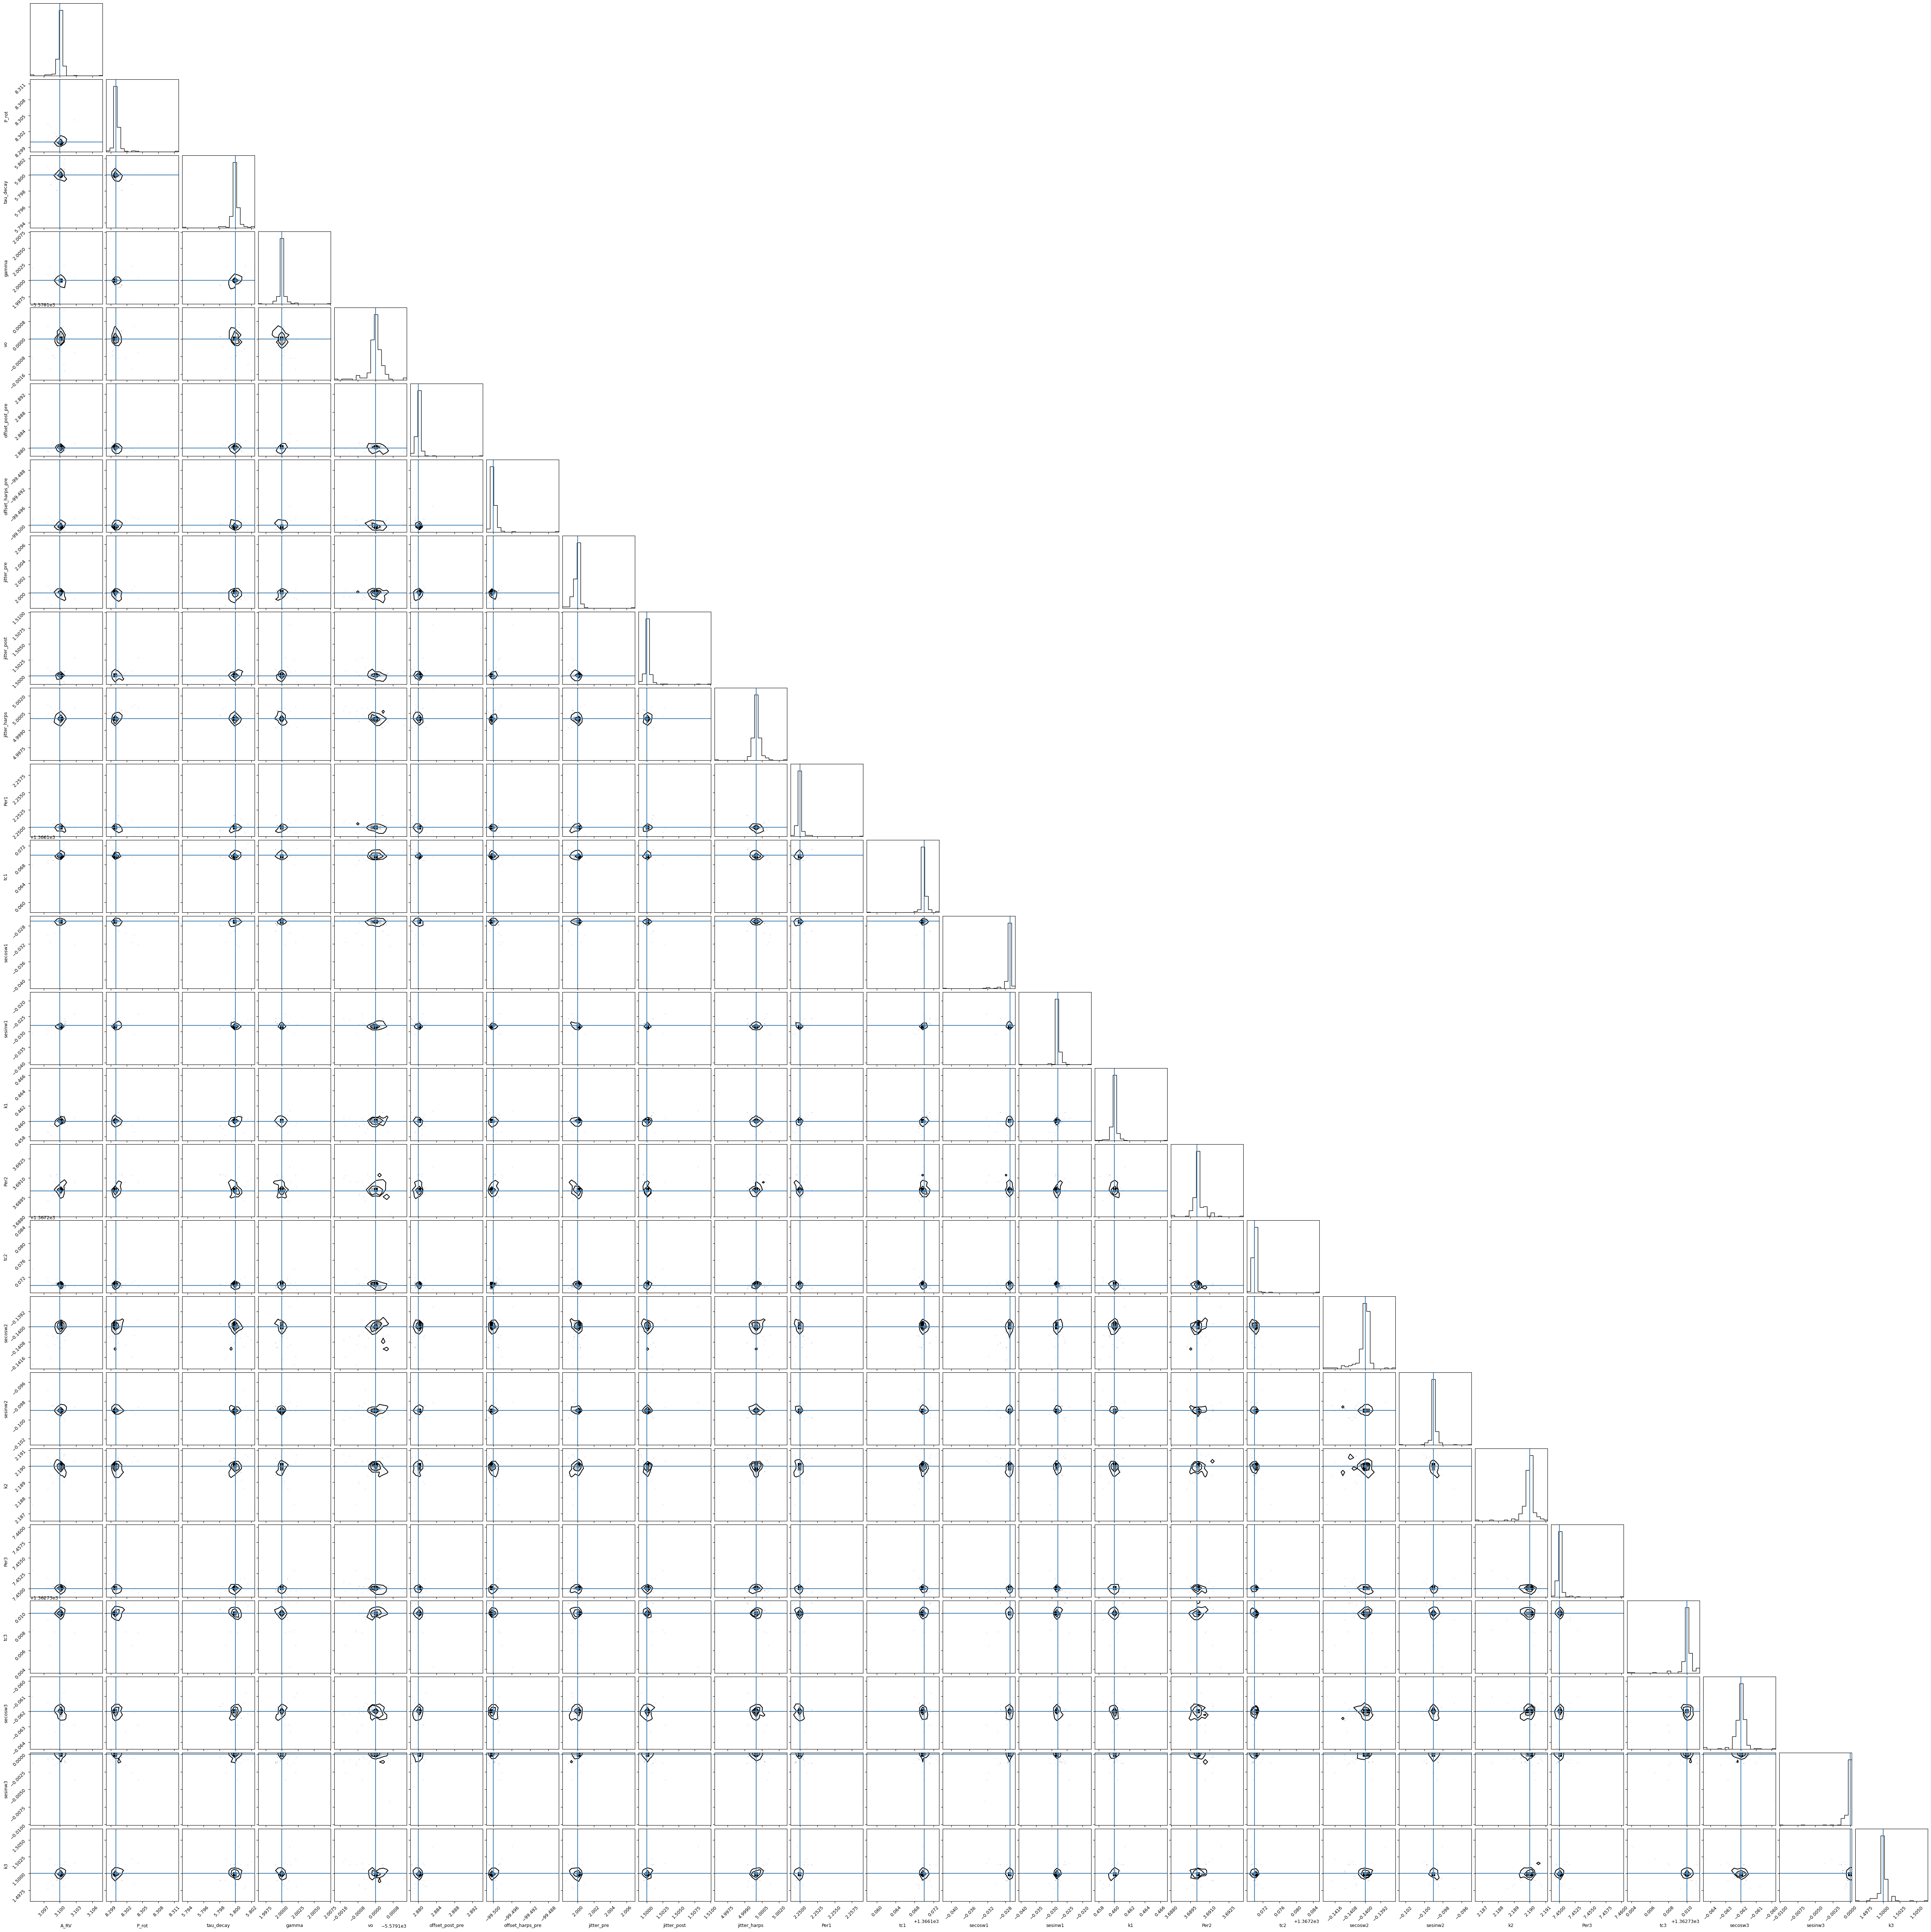

In [505]:
samples = sampler.get_chain(discard=1, thin=15, flat=True)

# GP mean
gp_mean = np.mean(samples, axis=0)
print("Mean GP parameters: ")
print("A_RV: ", gp_mean[0])
print("P_rot: ", gp_mean[1])
print("tau_decay: ", gp_mean[2])
print("gamma: ", gp_mean[3])
print("v0: ", gp_mean[4])
print("offset_post_pre: ", gp_mean[5])
print("offset_harps_pre: ", gp_mean[6])
print("jitter_pre: ", gp_mean[7])
print("jitter_post: ", gp_mean[8])
print("jitter_harps: ", gp_mean[9])
print("Per1: ", gp_mean[10])
print("tc1: ", gp_mean[11])
print("secosw1: ", gp_mean[12])
print("sesinw1: ", gp_mean[13])
print("k1: ", gp_mean[14])
print("Per2: ", gp_mean[15])
print("tc2: ", gp_mean[16])
print("secosw2: ", gp_mean[17])
print("sesinw2: ", gp_mean[18])
print("k2: ", gp_mean[19])
print("Per3: ", gp_mean[20])
print("tc3: ", gp_mean[21])
print("secosw3: ", gp_mean[22])
print("sesinw3: ", gp_mean[23])
print("k3: ", gp_mean[24])

labels=['A_RV', 'P_rot', 'tau_decay', 'gamma', 'vo', 'offset_post_pre', 'offset_harps_pre', 'jitter_pre', 'jitter_post', 'jitter_harps', 'Per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'Per2', 'tc2', 'secosw2', 'sesinw2', 'k2', 'Per3', 'tc3', 'secosw3', 'sesinw3', 'k3']

figure = corner.corner(samples, labels=labels, truths=params)

### GP Model Setup

In [364]:
# gp log-priors
def gp_log_prior(params):
    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # unifrom priors; A_RV, gamma, jitter_pre, jitter_post, jitter_harps
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)
    
    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    # Ensure P_rot and tau_decay are within bounds
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    # Additional condition
    if tau_decay < P_rot / 2:
        return -np.inf  # Condition that tau_decay must be greater than half of P_rot
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    # Combine priors
    total_prior = prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre + prior_jitter_pre + prior_jitter_post + prior_jitter_harps

    return total_prior

### Radvel Model Setup

In [366]:
# radvel params
def radvel_setup_model():
    time_base = 0
    params = radvel.Parameters(3, basis='per tc secosw sesinw k')

    # L 98-59 b
    params['per1'] = radvel.Parameter(value=2.25)
    params['tc1'] = radvel.Parameter(value=1366.17)
    params['secosw1'] = radvel.Parameter(value=-0.027)
    params['sesinw1'] = radvel.Parameter(value=-0.028)
    params['k1'] = radvel.Parameter(value=0.46)

    # L 98-59 c
    params['per2'] = radvel.Parameter(value=3.69)
    params['tc2'] = radvel.Parameter(value=1367.27)
    params['secosw2'] = radvel.Parameter(value=-0.14)
    params['sesinw2'] = radvel.Parameter(value=-0.099)
    params['k2'] = radvel.Parameter(value=2.19)

    # L 98-59 d
    params['per3'] = radvel.Parameter(value=7.45)
    params['tc3'] = radvel.Parameter(value=1362.74)
    params['secosw3'] = radvel.Parameter(value=-0.062)
    params['sesinw3'] = radvel.Parameter(value=0)
    params['k3'] = radvel.Parameter(value=1.50)

    mod = radvel.RVModel(params, time_base=time_base)
    return mod

In [378]:
'''def radvel_likelihood(params, mod, *args):

    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # rv data
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args

    # Jitter and offset
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the likelihoods
    l_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre)
    l_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post)
    l_rv_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps)

    # Composite likelihood
    likes = radvel.likelihood.CompositeLikelihood([l_rv_pre, l_rv_post, l_rv_harps])

    # stop gamma and jit varying
    likes.params['gamma'].vary = False
    likes.params['jit'].vary = False

    return likes


def radvel_priors(likes, params):
    post = radvel.posterior.Posterior(likes)

    # priors
    #  L 98-59 b
    e1 = np.sqrt(params['secosw1'].value**2 + params['sesinw1'].value**2)
    omega1 = np.arctan2(params['sesinw1'].value, params['secosw1'].value)
    phi1 = calculate_orbital_phase(params['tc1'].value, 0, params['per1'].value)

    # Define priors
    post.priors = [
    radvel.prior.Jeffreys('per1', 0.1, 520),
    beta_prior(e1, 0.867, 3.03),
    uniform_prior(omega1, -np.pi, np.pi),
    uniform_prior(params['k1'].value, 0, 17),
    uniform_prior(phi1, 0, 1)
    ]

    # L 98-59 c
    e2 = np.sqrt(params['secosw2'].value**2 + params['sesinw2'].value**2)
    omega2 = np.arctan2(params['sesinw2'].value, params['secosw2'].value)
    phi2 = calculate_orbital_phase(params['tc2'].value, 0, params['per2'].value)

    # Define priors
    post.priors += [
    radvel.prior.Jeffreys('per2', 0.1, 520),
    beta_prior(e2, 0.867, 3.03),
    uniform_prior(omega2, -np.pi, np.pi),
    uniform_prior(params['k2'].value, 0, 17),
    uniform_prior(phi2, 0, 1)
    ]

    # L 98-59 d
    e3 = np.sqrt(params['secosw3'].value**2 + params['sesinw3'].value**2)
    omega3 = np.arctan2(params['sesinw3'].value, params['secosw3'].value)
    phi3 = calculate_orbital_phase(params['tc3'].value, 0, params['per3'].value)

    # Define priors
    post.priors += [
    radvel.prior.Jeffreys('per3', 0.1, 520),
    beta_prior(e3, 0.867, 3.03),
    uniform_prior(omega3, -np.pi, np.pi),
    uniform_prior(params['k3'].value, 0, 17),
    uniform_prior(phi3, 0, 1)
    ]

    return post


likes = radvel_likelihood([1, 10, 100, 0.1, -5579.1, 2.88, -99.5, 0.1, 0.1, 0.1], radvel_setup_model(), time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps)
params = likes.params
post = radvel_priors(likes, params)

post'''

"def radvel_likelihood(params, mod, *args):\n\n    # gp hyperparameters\n    A_RV, P_rot, tau_decay, gamma = params[:4]\n    \n    # instrumental model hyperparameters\n    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]\n\n    # rv data\n    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args\n\n    # Jitter and offset\n    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)\n    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)\n    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)\n\n    rv_pre_adjusted = rv_pre - v0\n    rv_post_adjusted = rv_post - v0 - offset_post_pre\n    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre\n\n    # Compute the likelihoods\n    l_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre)\n    l_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post)\n    l_rv_harps = radvel.likelihood.RVLikelihood(mod, time_

In [324]:

'''# radvel log-prior
def radvel_log_prior(params, mod):

    # Update RadVel model parameters
    mod.params['per1'].value = params[10]
    mod.params['tc1'].value = params[11]
    mod.params['secosw1'].value = params[12]
    mod.params['sesinw1'].value = params[13]
    mod.params['k1'].value = params[14]
    mod.params['per2'].value = params[15]
    mod.params['tc2'].value = params[16]
    mod.params['secosw2'].value = params[17]
    mod.params['sesinw2'].value = params[18]
    mod.params['k2'].value = params[19]
    mod.params['per3'].value = params[20]
    mod.params['tc3'].value = params[21]
    mod.params['secosw3'].value = params[22]
    mod.params['sesinw3'].value = params[23]
    mod.params['k3'].value = params[24]

    
    # L 98-59 b
    e1 = np.sqrt(params[12]**2 + params[13]**2)
    omega1 = np.arctan2(params[13], params[12])
    phi1 = calculate_orbital_phase(params[11], 0, params[10])

    # Define priors
    priors = [
    radvel.prior.Jeffreys('per1', 0.1, 520),
    beta_prior(e1, 0.867, 3.03),
    uniform_prior(omega1, -np.pi, np.pi),
    uniform_prior(params[14], 0, 17),
    uniform_prior(phi1, 0, 1)
    ]

    # L 98-59 c
    e2 = np.sqrt(params[17]**2 + params[18]**2)
    omega2 = np.arctan2(params[18], params[17])
    phi2 = calculate_orbital_phase(params[16], 0, params[15])

    # Define priors
    priors += [
    radvel.prior.Jeffreys('per2', 0.1, 520),
    beta_prior(e2, 0.867, 3.03),
    uniform_prior(omega2, -np.pi, np.pi),
    uniform_prior(params[19], 0, 17),
    uniform_prior(phi2, 0, 1)
    ]

    # L 98-59 d
    e3 = np.sqrt(params[22]**2 + params[23]**2)
    omega3 = np.arctan2(params[23], params[22])
    phi3 = calculate_orbital_phase(params[21], 0, params[20])
    
    # Define priors
    priors += [
    radvel.prior.Jeffreys('per3', 0.1, 520),
    beta_prior(e3, 0.867, 3.03),
    uniform_prior(omega3, -np.pi, np.pi),
    uniform_prior(params[24], 0, 17),
    uniform_prior(phi3, 0, 1)
    ]

    return sum(prior.logprob() for prior in priors)'''

"# radvel log-prior\ndef radvel_log_prior(params, mod):\n\n    # Update RadVel model parameters\n    mod.params['per1'].value = params[10]\n    mod.params['tc1'].value = params[11]\n    mod.params['secosw1'].value = params[12]\n    mod.params['sesinw1'].value = params[13]\n    mod.params['k1'].value = params[14]\n    mod.params['per2'].value = params[15]\n    mod.params['tc2'].value = params[16]\n    mod.params['secosw2'].value = params[17]\n    mod.params['sesinw2'].value = params[18]\n    mod.params['k2'].value = params[19]\n    mod.params['per3'].value = params[20]\n    mod.params['tc3'].value = params[21]\n    mod.params['secosw3'].value = params[22]\n    mod.params['sesinw3'].value = params[23]\n    mod.params['k3'].value = params[24]\n\n    \n    # L 98-59 b\n    e1 = np.sqrt(params[12]**2 + params[13]**2)\n    omega1 = np.arctan2(params[13], params[12])\n    phi1 = calculate_orbital_phase(params[11], 0, params[10])\n\n    # Define priors\n    priors = [\n    radvel.prior.Jeffrey

### Joint Log Likelihood

In [379]:
def combined_log_likelihood(params, rv_model, *args):
    # stellar activity hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # planet parameters
    rv_model.params['per1'] = params[10]
    rv_model.params['tc1'] = params[11]
    rv_model.params['secosw1'] = params[12]
    rv_model.params['sesinw1'] = params[13]
    rv_model.params['k1'] = params[14]
    rv_model.params['per2'] = params[15]
    rv_model.params['tc2'] = params[16]
    rv_model.params['secosw2'] = params[17]
    rv_model.params['sesinw2'] = params[18]
    rv_model.params['k2'] = params[19]
    rv_model.params['per3'] = params[20]
    rv_model.params['tc3'] = params[21]
    rv_model.params['secosw3'] = params[22]
    rv_model.params['sesinw3'] = params[23]
    rv_model.params['k3'] = params[24]

    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the likelihoods
    gp.compute(time_pre, err_pre)
    ll_gp_pre = gp.log_likelihood(rv_pre_adjusted)
    ll_rv_pre = radvel.likelihood.RVLikelihood(rv_model, time_pre, rv_pre_adjusted, err_pre).logprob()

    gp.compute(time_post, err_post)
    ll_gp_post = gp.log_likelihood(rv_post_adjusted)
    ll_rv_post = radvel.likelihood.RVLikelihood(rv_model, time_post, rv_post_adjusted, err_post).logprob()

    gp.compute(time_harps, err_harps)
    ll_gp_harps = gp.log_likelihood(rv_harps_adjusted)
    ll_rv_harps = radvel.likelihood.RVLikelihood(rv_model, time_harps, rv_harps_adjusted, err_harps).logprob()
    

    # Composite likelihood
    ll_rv = radvel.likelihood.CompositeLikelihood([ll_rv_pre, ll_rv_post, ll_rv_harps])
    ll_gp = np.sum([ll_gp_pre, ll_gp_post, ll_gp_harps])

    return ll_rv + ll_gp + gp_log_prior(params)


In [325]:
# combined log-likehood
def log_likelihood(params, mod, *args):
    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]
    # rv data
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args

    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the ll for each instrument GP and Radvel
    gp.compute(time_pre, err_pre)
    ll_gp_pre = gp.log_likelihood(rv_pre_adjusted)
    ll_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre).logprob()

    gp.compute(time_post, err_post)
    ll_gp_post = gp.log_likelihood(rv_post_adjusted)
    ll_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post).logprob()

    gp.compute(time_harps, err_harps)
    ll_gp_harps = gp.log_likelihood(rv_harps_adjusted)
    ll_rv_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps).logprob()

    

    return ll_gp_pre + ll_rv_pre + ll_gp_post + ll_rv_post + ll_gp_harps + ll_rv_harps

### Combined Model

In [380]:
def log_prior(params, mod):
    return gp_log_prior(params) 

def log_posterior(params, mod, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, mod, *args)

def log_prob(params, mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps):
    return log_prior(params, mod) + log_likelihood(params, mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps)

#### GP all 

In [202]:
# Define the kernel using parameter values that will be sampled by MCMC
def create_kernel(A_RV, P_rot, tau_decay, gamma):
    # Quasi-periodic kernel
    kernel = A_RV**2 * kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P_rot)) * kernels.ExpSquaredKernel(metric=tau_decay**2)
    return kernel

# Define the log prior function
def log_prior(params):
    # params
    A_RV, P_rot, tau_decay, gamma,\
        v0, offset_post_pre, offset_harps_pre,\
            jitter_pre, jitter_post, jitter_harps = params
    
    # unifrom priors; A_RV, gamma, jitter_pre, jitter_post, jitter_harps
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)
    
    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    # Ensure P_rot and tau_decay are within bounds
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    # Additional condition
    if tau_decay < P_rot / 2:
        return -np.inf  # Condition that tau_decay must be greater than half of P_rot
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    # Combine priors
    total_prior = prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre + prior_jitter_pre + prior_jitter_post + prior_jitter_harps

    return total_prior

# Define the log likelihood function
def log_likelihood(params, *args):
    # unpack the arguments

    A_RV, P_rot, tau_decay, gamma, v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params
    
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args
    
    
    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the GP for each instrument
    gp.compute(time_pre, err_pre)
    ll_pre = gp.log_likelihood(rv_pre_adjusted)

    gp.compute(time_post, err_post)
    ll_post = gp.log_likelihood(rv_post_adjusted)

    gp.compute(time_harps, err_harps)
    ll_harps = gp.log_likelihood(rv_harps_adjusted)

    return ll_pre + ll_post + ll_harps

# Define the log probability function
def log_prob(params, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, *args)

### Pre-Minimization

In [271]:
# Define the negative log posterior
def neg_log_posterior(params, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return np.inf
    return -(lp + log_likelihood(params, *args))

# Sample initial guesses from the priors
def sample_from_priors():
    return [
        np.random.uniform(0, 17),  # A_RV
        np.random.uniform(5, 520),  # P_rot
        np.random.uniform(2.5, 2600),  # tau_decay
        np.random.uniform(0.05, 5),  # gamma
        np.random.normal(-5579.1, 3.5),  # v0
        np.random.normal(2.88, 4.8),  # offset_post_pre
        np.random.normal(-99.5, 5.0),  # offset_harps_pre
        np.random.uniform(0, 4.5),  # jitter_pre
        np.random.uniform(0, 3.6),  # jitter_post
        np.random.uniform(0, 11)  # jitter_harps
    ]

def robust_minimize(func, initial_guess_func, args=(), max_attempts=500, method='Nelder-Mead', **kwargs):
    attempt = 0
    while attempt < max_attempts:
        initial_guess = initial_guess_func()
        try:
            result = minimize(func, initial_guess, args=args, method=method, **kwargs)
            if result.success:
                print(f"Optimization successful on attempt {attempt + 1}")
                return result
        except Exception as e:
            print(f"Optimization attempt {attempt + 1} failed with error: {e}")
        attempt += 1
    print("All optimization attempts failed.")
    return None

# Run the optimization
result = robust_minimize(neg_log_posterior, sample_from_priors, args=(time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps))

# Print the results
if result is not None:
    print("Optimization result:", result)
else:
    print("No successful optimization was found.")

Optimization attempt 1 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 2 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 3 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 4 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 5 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 6 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 7 failed with error

In [208]:
result.x

print("Minimization result: ")
print("A_RV: ", result.x[0])
print("P_rot: ", result.x[1])
print("tau_decay: ", result.x[2])
print("gamma: ", result.x[3])
print("v0: ", result.x[4])
print("offset_post_pre: ", result.x[5])
print("offset_harps_pre: ", result.x[6])
print("jitter_pre: ", result.x[7])
print("jitter_post: ", result.x[8])
print("jitter_harps: ", result.x[9])

Minimization result: 
A_RV:  4.4968577423458193e-07
P_rot:  5.110143903661077
tau_decay:  2.5551439603686585
gamma:  2.1412370838052137
v0:  -5577.584372183343
offset_post_pre:  -0.5082015813834981
offset_harps_pre:  -100.2648855022631
jitter_pre:  4.499999486947137
jitter_post:  2.256400527732822
jitter_harps:  6.146148162554082


### MCMC

In [381]:
args = time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
true_params = [2.4, 33, 49, 3.2, -5579, 1.2, -99.13, 0.88, 0.91, 0.32]
#result_params = result.x

mod = radvel_setup_model()

test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,  # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,  # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5   # jitter_harps U(0, 11)
]

params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,    # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,    # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5,    # jitter_harps U(0, 11)
    2.25, # RadVel per1
    1366.17, # RadVel tc1
    -0.027, # RadVel secosw1
    -0.028, # RadVel sesinw1
    0.46,  # RadVel k1
    3.69,  # RadVel per2
    1367.27, # RadVel tc2
    -0.14,  # RadVel secosw2
    -0.099, # RadVel sesinw2
    2.19,  # RadVel k2
    7.45,  # RadVel per3
    1362.74, # RadVel tc3
    -0.062, # RadVel secosw3
    0,     # RadVel sesinw3
    1.50   # RadVel k3
]


# Example call
print(log_likelihood(params, mod, *args))

-1338.377280267452


In [383]:
test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,  # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,  # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5   # jitter_harps U(0, 11)
]

test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,    # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,    # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5,    # jitter_harps U(0, 11)
    2.25, # RadVel per1
    1366.17, # RadVel tc1
    -0.027, # RadVel secosw1
    -0.028, # RadVel sesinw1
    0.46,  # RadVel k1
    3.69,  # RadVel per2
    1367.27, # RadVel tc2
    -0.14,  # RadVel secosw2
    -0.099, # RadVel sesinw2
    2.19,  # RadVel k2
    7.45,  # RadVel per3
    1362.74, # RadVel tc3
    -0.062, # RadVel secosw3
    0,     # RadVel sesinw3
    1.50   # RadVel k3
]



ndim, nwalkers = len(test_params), 50
pos = test_params + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps))

# Run MCMC
sampler.run_mcmc(pos, 50, progress=True)

100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


State([[ 1.64646313 10.50841802  6.75458852 ...  1.09983787 -2.84431281
   4.25255868]
 [ 2.80877804  8.72837566  6.08881843 ...  0.07925835 -0.23113275
   2.28353329]
 [ 1.62662822  8.56531945  6.07645103 ...  0.39567918 -1.55818572
   2.19342774]
 ...
 [ 2.43720984  7.92055966  6.09619237 ... -0.10204725 -0.54801632
   1.41422063]
 [ 2.90611947 10.18302092  6.58513135 ...  0.21240226 -0.17143005
   3.43392716]
 [ 2.23375919  6.91800151  6.04147701 ...  0.57805945 -3.26699361
   0.89131176]], log_prob=[-1299.46006375 -1310.98595971 -1299.59714978 -1348.4442678
 -1320.50783816 -1296.00461637 -1293.28447723 -1307.35768198
 -1310.02064626 -1301.66363698 -1284.54818411 -1293.59464573
 -1311.61820565 -1286.08780126 -1294.25754324 -1313.68018735
 -1312.73307873 -1299.54434964 -1301.18281467 -1320.67952981
 -1298.74614311 -1311.72894996 -1290.5523669  -1304.5048067
 -1317.88335426 -1309.54804708 -1315.91136966 -1280.45503935
 -1290.32453361 -1300.7631466  -1290.43696336 -1313.85586774
 -1299

Mean GP parameters: 
A_RV:  2.964993071155044
P_rot:  8.287992670155631
tau_decay:  5.774250628449793
gamma:  1.9549696655191542
v0:  -5578.949679254059
offset_post_pre:  2.7647526161985048
offset_harps_pre:  -99.49664293532955
jitter_pre:  2.2195493955813337
jitter_post:  1.703788008906663
jitter_harps:  4.608780329191851
Per1:  2.4677987038703115
tc1:  1365.72528478768
secosw1:  -0.22721484113790122
sesinw1:  0.12752704584856206
k1:  0.6464925592454588
Per2:  3.4586902818570766
tc2:  1367.2972934861011
secosw2:  -0.18408524893325173
sesinw2:  -0.32836940418497956
k2:  1.5091306706343186
Per3:  7.2759853446493175
tc3:  1362.93027724755
secosw3:  0.4884597728918865
sesinw3:  0.1373227484094232
k3:  1.5438981484441854
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid co

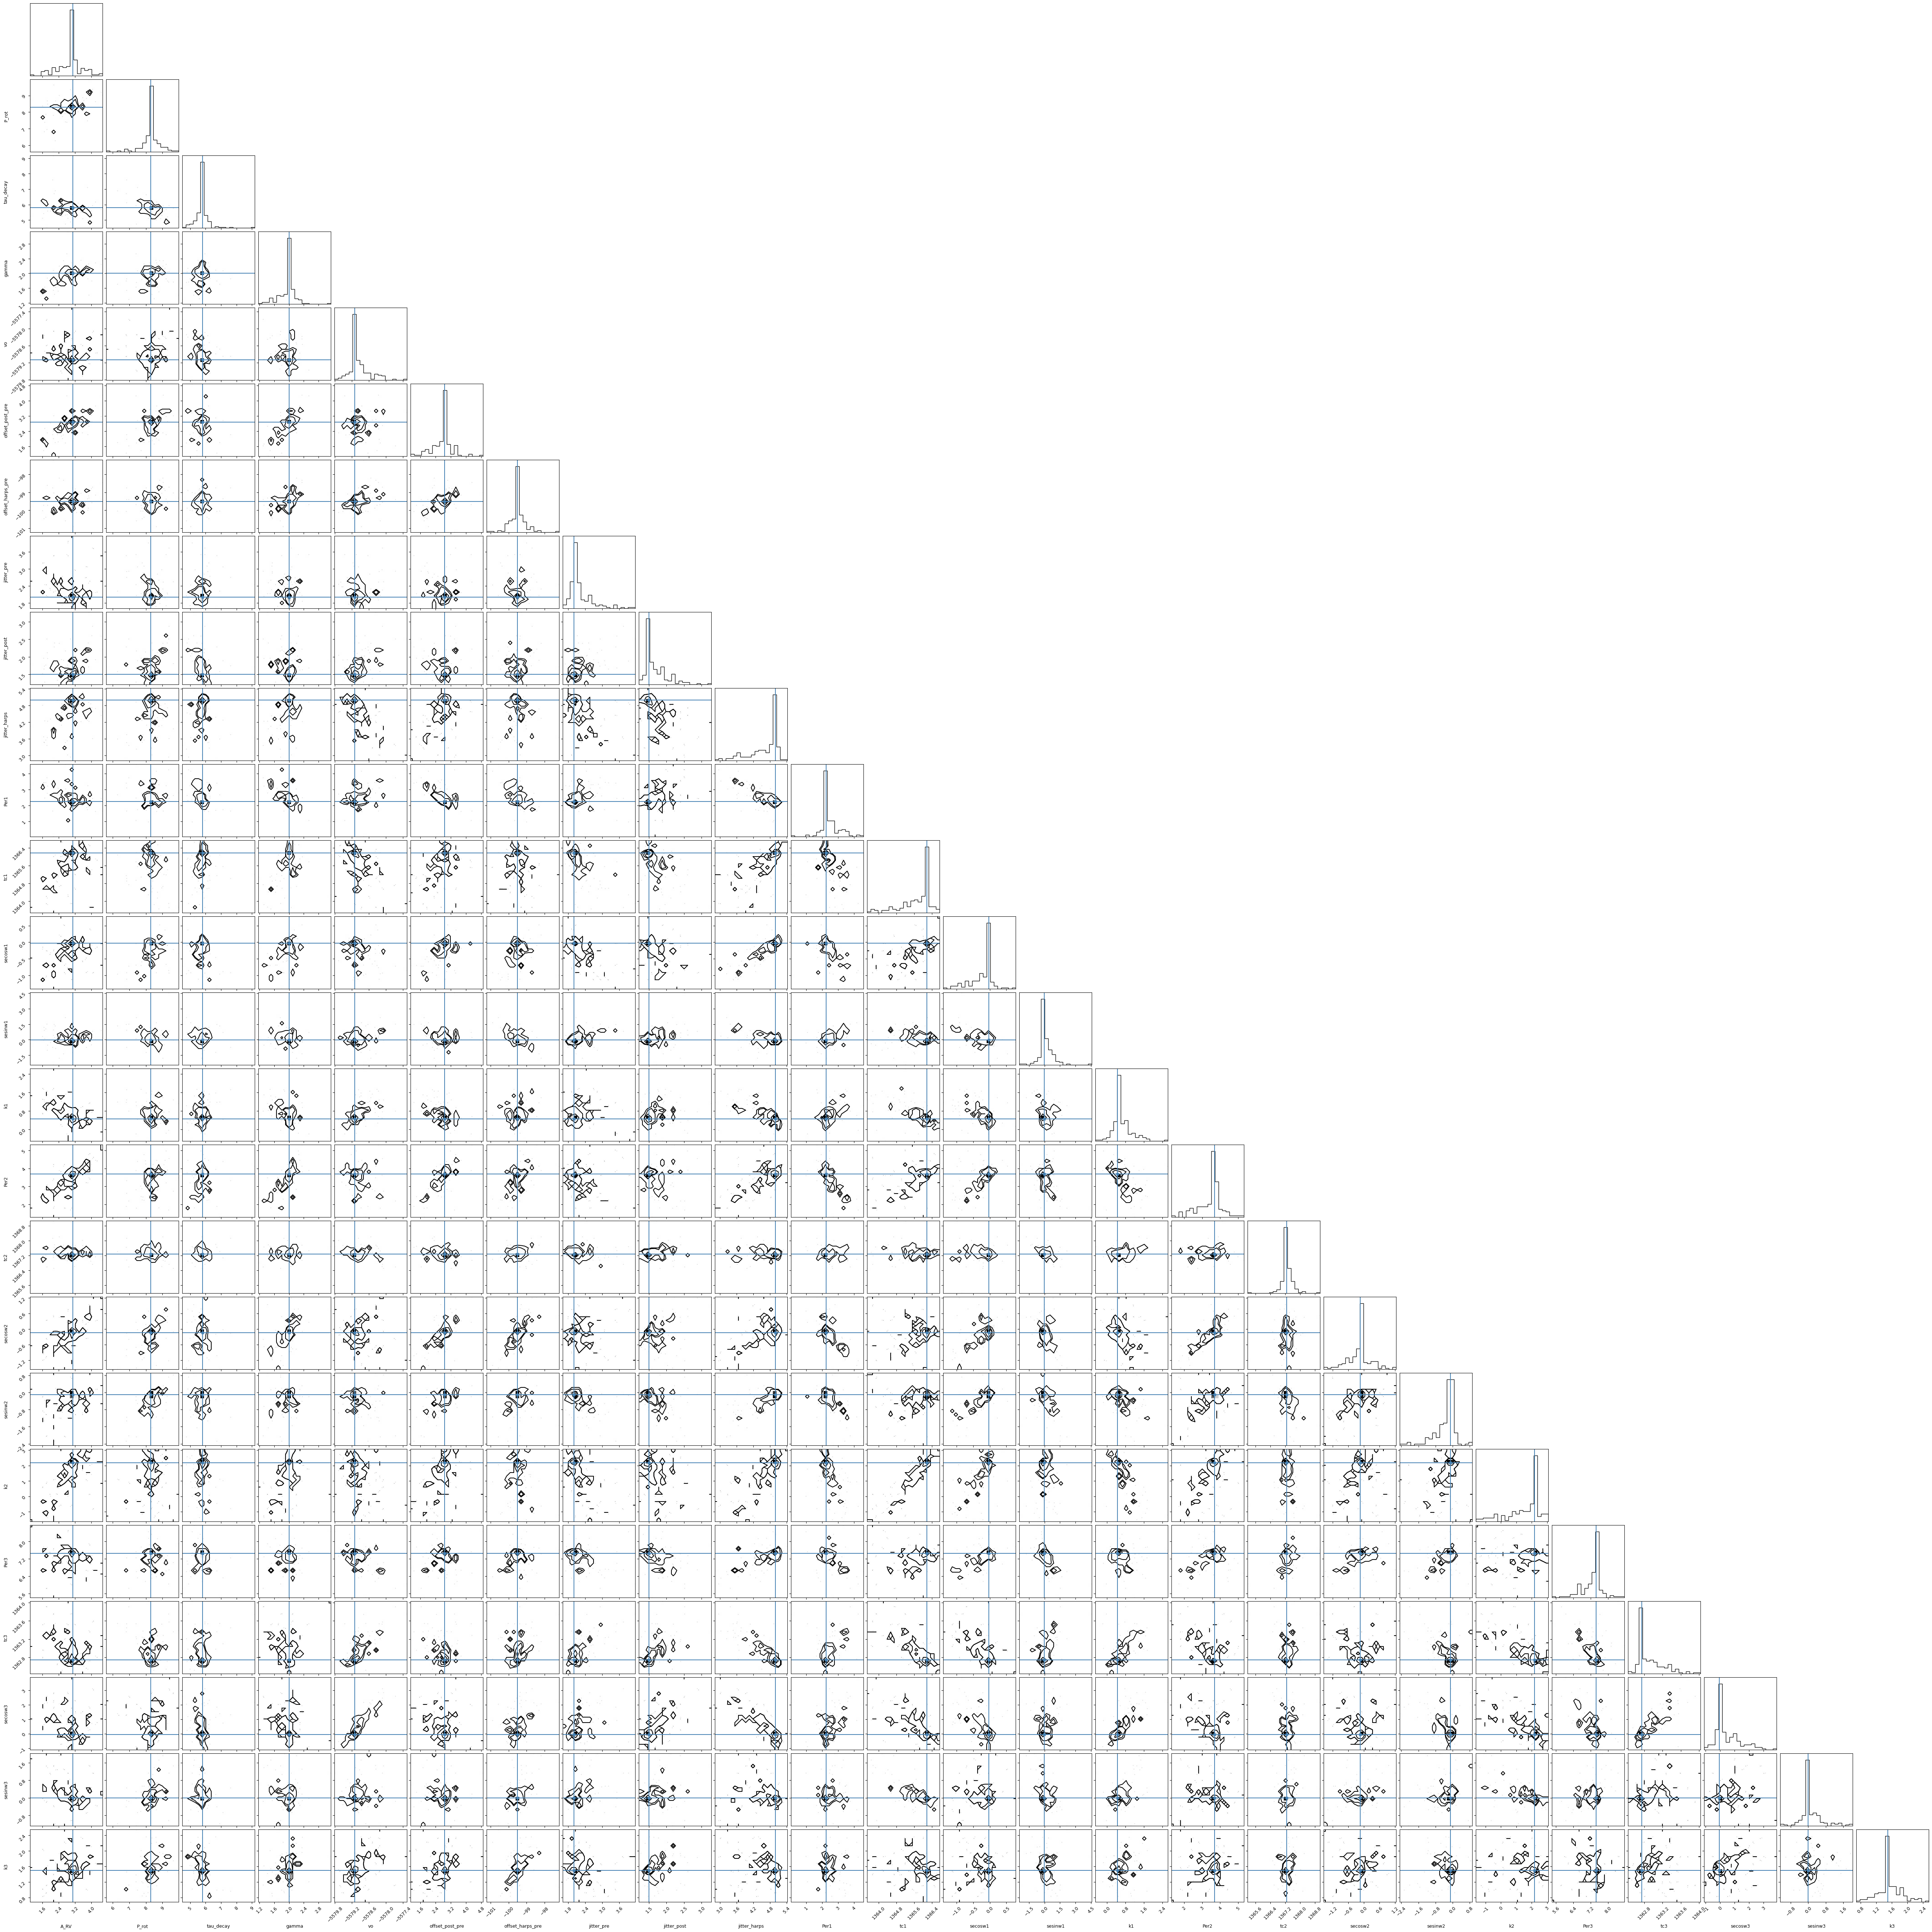

In [338]:
samples = sampler.get_chain(discard=1, thin=15, flat=True)

# GP mean
gp_mean = np.mean(samples, axis=0)
print("Mean GP parameters: ")
print("A_RV: ", gp_mean[0])
print("P_rot: ", gp_mean[1])
print("tau_decay: ", gp_mean[2])
print("gamma: ", gp_mean[3])
print("v0: ", gp_mean[4])
print("offset_post_pre: ", gp_mean[5])
print("offset_harps_pre: ", gp_mean[6])
print("jitter_pre: ", gp_mean[7])
print("jitter_post: ", gp_mean[8])
print("jitter_harps: ", gp_mean[9])
print("Per1: ", gp_mean[10])
print("tc1: ", gp_mean[11])
print("secosw1: ", gp_mean[12])
print("sesinw1: ", gp_mean[13])
print("k1: ", gp_mean[14])
print("Per2: ", gp_mean[15])
print("tc2: ", gp_mean[16])
print("secosw2: ", gp_mean[17])
print("sesinw2: ", gp_mean[18])
print("k2: ", gp_mean[19])
print("Per3: ", gp_mean[20])
print("tc3: ", gp_mean[21])
print("secosw3: ", gp_mean[22])
print("sesinw3: ", gp_mean[23])
print("k3: ", gp_mean[24])

labels=['A_RV', 'P_rot', 'tau_decay', 'gamma', 'vo', 'offset_post_pre', 'offset_harps_pre', 'jitter_pre', 'jitter_post', 'jitter_harps', 'Per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'Per2', 'tc2', 'secosw2', 'sesinw2', 'k2', 'Per3', 'tc3', 'secosw3', 'sesinw3', 'k3']

figure = corner.corner(samples, labels=labels, truths=params)

### Visual Inspection

In [217]:
time_pred = np.linspace(min(time_harps), max(time_post), 1000)

# plot
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>